### Packages needed

In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

#import torch
#import torch.nn as nn
#import torch.nn.parallel
#import torch.optim as optim
#import torch.utils.data

#from torch.nn import functional
#from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics

#!pip install dtaidistance
#!pip install plotly
#!pip install tslearn
#source https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html
#from dtaidistance import dtw
#from dtaidistance import dtw_visualisation as dtwvis

from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import xml.etree.ElementTree as ET

import geopandas as gpd

import copy 

import json

#binary factorization
import nimfa

from sklearn.decomposition import NMF
import scipy.sparse as sparse
import implicit

#extract number from str
import re

In [3]:
#!pip install pysal

In [2]:
#!pip install Cython
#!pip install Cython --install-option="--no-cython-compile"
#%load_ext cython
#from setuptools import setup
#from Cython.Build import cythonize

### data processing

In [5]:
#defined functions
def get_time_variationbyzone(data, taz, time_loc, plot_index):
    data_taz = data[data['taz']==taz]
    data_taz = data_taz.sort_values(by=['hr', 'min'])
    data_taz = data_taz.groupby(by=['hr', 'min']).sum()
    
    data_taz.reset_index(inplace=True)
    data_taz = data_taz[['hr','min','sum']]
    #data_taz
    obs_sum = np.zeros((len(time_loc)))
    hr_ = data_taz['hr'].values
    min_ = data_taz['min'].values
    sum_val = data_taz['sum'].values
    
    for i in range(len(hr_)):
        obs_sum[time_loc[str(hr_[i])+'_'+str(min_[i])]] = sum_val[i]
    #use obs/max(obs) instead of obs/sum(obs) 
    obs_per = obs_sum/(np.max(obs_sum))
    
    if plot_index == True:
        fig = plt.figure(taz)
        plt.plot(obs_sum)
    return(obs_per)

def get_sim_obs_ts(fcd_out, taz_time_per, avg_per, return_sim=True):
    taz_ = fcd_out['taz'].values
    time_5 = fcd_out['time_5'].values
    per_ts = []
    for i in range(len(taz_)):
        if taz_[i] in taz_time_per:
            per_ts.append(taz_time_per[taz_[i]][time_5[i]])
        else:
            per_ts.append(avg_per[time_5[i]])
    if return_sim == True:
        sim_obs_ts = [] 
        for i in range(len(per_ts)):
            sim_obs_ts.append(np.random.binomial(1, per_ts[i], 1)[0])
        return(sim_obs_ts)
    else:
        return(per_ts)
    

#convert dt to matrix
def read_fcd(fcd_dt_path, app_based_data):
    fcd_out = pd.read_csv(fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']
    fcd_out.taz = fcd_out.taz.astype('int')
    
    
    revise_dt = lambda x: x.split('-')[0] if '-' in x else x
    get_sample_index = lambda x: x.split('-')[2] if '-' in x else 3
    fcd_out['reids'] = fcd_out['id'].apply(revise_dt)
    fcd_out['sample_index'] = (fcd_out['id'].apply(get_sample_index)).astype(int)
    
    fcd_out['time'] = fcd_out['time'].astype('int')
    fcd_out['hr'] = (fcd_out['time'].values/3600).astype(int)
    fcd_out['minus'] = ((fcd_out['time'].values- fcd_out['hr'].values*3600)/60).astype(int)
    fcd_out['time_30'] = (fcd_out['time']/30).astype(int)
    fcd_out['time_5'] = (fcd_out['time']/300).astype(int)
    
    print('num id', len(np.unique(fcd_out.reids)))

    #fcd_out.sort_values(by=['time', 'taz'])
    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+(fcd_out['time_5']).astype(str)

    time_ = np.unique((fcd_out['time']/300).astype(int))
    
    if app_based_data == True:
        #sample index 0: non app-based samples, 1: app=based samples, 3: transit
        #fcd_out.groupby(by=['sample_index']).size()
        #sample_index 0    1714901, 1     572267, 3     180802
        return(fcd_out[fcd_out['sample_index']!=0])
    else:
        return(fcd_out)
    
def getfcdnorigindt(fcd_out, savepath, 
                    data_obs, time_loc, taz_time_per, avg_per, 
                    save_index):
    #get one day data (use 5 min as the time interval)
    #fcd_out = fcd_out[fcd_out['time_5']<288]
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.reids):
        newuser_[i] = index_
        index_ += 1    
    ## fcd output processing
    #delete the data exceeds the 24-hr daily period
    #fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    fcd_out.time = fcd_out.time.astype('int')

    obs = data_obs.groupby(by=['time']).size().values
    obs_per = obs/max(obs)

    sample_ct = lambda x: np.random.binomial(1, obs_per[x], 1)[0]

    fcd_out['sim_obs'] = fcd_out['time_5'].apply(sample_ct)

    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)
    
    sim_obs = get_sim_obs_ts(fcd_out, taz_time_per, avg_per, True)
    fcd_out['sim_obs_ts'] = sim_obs

    #simulated observations based on time variation
    print('sim based on time', 
          np.count_nonzero(fcd_out['sim_obs'])/fcd_out.shape[0])

    #simulated observations based on time and spatial variation
    print('sim based on time and spatial',
          np.count_nonzero(fcd_out['sim_obs_ts'])/fcd_out.shape[0])
    
    return(fcd_out)

#fcd_out = read_fcd(fcd_dt_path, app_based_data)
def run_sim(csv_path, fcd_out, savepath, save_index=False, plot_index=True):
    data_obs = pd.read_csv(csv_path, header=0)
    print('app based data', data_obs.head(3))
    
    newids = np.unique(data_obs.newid)
    newid_ = {}
    index_ = 0
    for i in range(len(newids)):
        newid_[newids[i]] = index_
        index_ += 1
        
    get_hr = lambda x: x.split(':')[0]
    get_min = lambda x: x.split(':')[1]

    hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
    min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
    taz_ = np.unique(data_obs['taz'])

    data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
    data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)
    
    index_ = 0
    lt_loc = {}
    for taz in taz_:
        for h in hr_:
            for m in min_:
                lt_loc['4_'+str(h)+'_'+str(m)+'_'+str(taz)] = index_
                index_ += 1
    obs_mx = np.zeros((len(newid_), len(lt_loc)))

    newid_col = data_obs.newid.values
    key_col = data_obs.key.values
    ct_col = data_obs['sum'].values

    for i in range(len(newid_col)):
        obs_mx[newid_[newid_col[i]]][lt_loc[key_col[i]]] = 1

    total_ct = np.sum(obs_mx, axis=0)
    #get ct based on taz and time
    total_ct = total_ct.reshape(1, total_ct.shape[0])
    total_ct_conver = np.hsplit(total_ct, len(taz_))
    max_num = np.max(np.array(total_ct_conver), axis=2)
    
    if plot_index == True:
        plt.plot(data_obs.groupby(by=['time']).size().values)
        
    time_loc = {}
    index_ = 0
    for hr in hr_:
        for miuts in min_:
            time_loc[str(hr)+'_'+str(miuts)] = index_
            index_ += 1

    taz_time_per = {}
    avg_per = 0
    index_ = 0 
    for taz_id in taz_:
        taz_time_per[taz_id] = get_time_variationbyzone(data_obs, taz_id, time_loc, plot_index)
        if index_ == 0:
            avg_per = taz_time_per[taz_id]
        else:
            avg_per = avg_per + taz_time_per[taz_id]
        index_ += 1
        
    avg_per = avg_per/np.max(avg_per)
    if plot_index == True:
        fig = plt.figure(1)
        plt.plot(avg_per)
        
    
    fcd_out = getfcdnorigindt(fcd_out, savepath, data_obs, time_loc, taz_time_per, avg_per, save_index=False)
    
    fcd_out['obs'] = 1
    #simulation compare
    print('sim_t vs sim_ts', mean_squared_error(fcd_out.sim_obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_ts', mean_squared_error(fcd_out.obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_t', mean_squared_error(fcd_out.obs, fcd_out.sim_obs, squared=False))
    
    return(fcd_out)   


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)

def get_pred_dt(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    #print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  


def get_simdt(fcd_out, sim_col, newuser_, loc_time):
    sim_dt = np.zeros((len(newuser_), len(loc_time)))
    fcd_obs = fcd_out[['reids', 'tl_id', 'sim_obs']].groupby(by=['reids', 'tl_id']).sum()
    fcd_obs.reset_index(inplace=True) 
    ids_ = fcd_obs['reids'].values
    tl_id_ = fcd_obs['tl_id'].values
    sim_obs = fcd_obs['sim_obs'].values
    for i in range(len(ids_)):
        sim_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = sim_obs[i]
    return(sim_dt)

def fit_dt(fcd_out, sim_col, newuser_, loc_time, k_val): 
    sim_dt = get_simdt(fcd_out, sim_col, newuser_, loc_time)
    #predict data based on time
    model = NMF(n_components=k_val, init='random', random_state=0)
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def get_index_lst(i, num_taz, num_time):
    return(list(np.arange(i, (num_time-1)*num_taz+i, num_time)))

#sep_dict = {'mor':[6, 9]
#            'noon':[9, 17]
#            'eve':[17, 20]}
def sep_indexdetime(num_taz, num_time, time_interval):
    sep_time = {'mor':[],
               'noon':[],
               'eve':[],
               'other':[]}
    for i in range(num_time):
        if i>=6*time_interval and i < 9*time_interval:
            sep_time['mor'].extend(get_index_lst(i, num_taz, num_time))
        elif i >= 9*time_interval and i < 17*time_interval:
            sep_time['noon'].extend(get_index_lst(i, num_taz, num_time))
        elif i>17*time_interval and i <20*time_interval:
            sep_time['eve'].extend(get_index_lst(i, num_taz, num_time))
        else:
            sep_time['other'].extend(get_index_lst(i, num_taz, num_time))
            
    for key in sep_time:
        sep_time[key] = sorted(sep_time[key])
    return(sep_time)

def fit_dtbytime(sim_dt, num_taz, num_time, time_interval, k_val, save_name):
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')

def del_transit_oneobs(fcd_out):
    fcd_transit = fcd_out[fcd_out['sample_index']==3]
    fcd_transit = fcd_transit.groupby(by=['id']).size().to_frame()
    fcd_transit.reset_index(inplace=True)
    fcd_transit_ids = fcd_transit[['id']][fcd_transit[0]==1].values.flatten()
    #print(fcd_transit_ids)
    print('# o ftransit line with only one obs deleted', len(fcd_transit_ids))
    return(fcd_out[~fcd_out['id'].isin(fcd_transit_ids)])

def get_test_dt(fcd_out, selected_ids):
    fcd_test = (fcd_out[fcd_out['reids'].isin(selected_ids)]).sort_values(by=['reids', 'time_30'])
    fcd_test['od_taz'] = fcd_test['otaz'].astype(str)+'_'+fcd_test['dtaz'].astype(str)
    fcd_test = fcd_test.sort_values(by=['reids', 'time_30'])
    return(fcd_test)

def get_other_stay_od(fcd_ids):
    fcd_ids['otaz'] = fcd_ids['taz']
    fcd_ids['dtaz'] = fcd_ids[['taz']].shift(periods=-1, fill_value=fcd_ids['otaz'].values[-1])
    fcd_ids['od_taz'] = fcd_ids['otaz'].astype(str)+'_'+fcd_ids['dtaz'].astype(str)
    return(fcd_ids)

def get_stay_val(fcd_test, ids, other_index):
    fcd_ids = fcd_test[fcd_test['reids']==ids]
    if other_index == True:
        fcd_ids = get_other_stay_od(fcd_ids)

    fcd_index = fcd_ids.groupby(by=['od_taz', 'otaz','dtaz','time_5_new'], sort=False).size().to_frame()
    fcd_index.reset_index(inplace=True)
    fcd_index = fcd_index.sort_values(by=['time_5_new'])

    fcd_index['time_diff'] = fcd_index[['time_5_new']] - (fcd_index[['time_5_new']].shift(periods=1, fill_value=0))
    fcd_index['time_diff_index'] = fcd_index['time_diff']>1

    start_t = 0
    time_ = []
    taz_ = []
    first_index = False

    for i in range(fcd_index.shape[0]):
        #handle special condition, when the first index = 1
        if i == 0 and fcd_index.iloc[i, 5] == 1:
            first_index = True
        if fcd_index.iloc[i, 6] == True or first_index==True:
            add_time = np.arange(start_t, fcd_index.iloc[i, 3])
            time_.extend(add_time)
            taz_.extend(np.repeat(fcd_index.iloc[i, 1], len(add_time)))

        start_t = fcd_index.iloc[i, 3]+1

    if start_t-1 < 287:
        add_time = np.arange(start_t, 288)
        time_.extend(add_time)
        taz_.extend(np.repeat(fcd_index.iloc[i, 2], len(add_time)))
        
    return(np.vstack((np.repeat(ids, len(time_)), time_, taz_)))

def get_stays_mx(fcd_dt, selected_ids, other_index=False):
    fcd_test = get_test_dt(fcd_dt, selected_ids)
    index_ = 0
    for ids in np.unique(fcd_test['reids']):
        if index_ == 0:
            add_stay = get_stay_val(fcd_test, ids, other_index)
            index_ = 1
        else:
            add_stay_cur = get_stay_val(fcd_test, ids, other_index)
            add_stay = np.hstack((add_stay, add_stay_cur))
            
    return(add_stay.T)

#check add stay function
def add_stay_check(add_stay, selected_ids, fcd_out):
    #get fcd trip num based on the time
    fcd_trip_num = (fcd_out.sort_values(by=['reids', 'time_30'])).groupby(by=['reids', 'time_5'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    fcd_trip_num = fcd_trip_num.groupby(by=['reids'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    
    test = pd.DataFrame(add_stay)
    test.columns = ['reids', 'taz', 'time_5']
    test = test.groupby(by=['reids']).size().to_frame()
    test.columns = ['stay_num']
    test = test.join((fcd_trip_num[fcd_trip_num['reids'].isin(selected_ids)]).set_index('reids'))
    test.reset_index(inplace=True)
    test = test[~(test['reids'].isin(stays_[0].values))]
    test.columns = ['reids','stay_num', 'trip_num']
    test['total'] = test['stay_num']+test['trip_num']
    print(test['total'].describe())
    return(test[test['total']!=288])

#add ids with stays only
#time = np.range(0, 288)
def get_stays(stays_dt):
    for i in range(stays_dt.shape[0]):
        ids = stays_dt.iloc[i, 0]
        taz = stays_dt.iloc[i, 1]
        if i == 0 :
            stays = np.vstack((np.repeat(ids, 288),
                               np.arange(0, 288),
                               np.repeat(taz, 288)))
        else:
            stays = np.hstack((stays, np.vstack((np.repeat(ids, 288),
                                                 np.arange(0, 288),
                                                 np.repeat(taz, 288)))))
        
    return(stays.T)

def add_index(index_val, stay_mx):
    add_index = np.repeat(index_val, stay_mx.shape[0]).reshape(stay_mx.shape[0], 1)
    return(np.hstack((stay_mx, add_index)))

def join_dt(add_mx, colname, index_val):
    add_mx = add_index(index_val, add_mx)
    join_dt = pd.DataFrame(add_mx)
    join_dt.columns = colname
    return(join_dt)
    

#colname = ['reids', 'time_5', 'taz'], indexcol = 'col_index'
def get_filled_dt(stay, add_stay, add_stay_other, fcd_out, colname, indexcol):
    #add index to distinguish the filled dt
    fcd_dt = fcd_out[colname]
    fcd_dt[indexcol] = 3
    colname.append(indexcol)
    
    #add add stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay, colname, 0)])
    #add add other stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay_other, colname, 1)])
    #add stays only
    fcd_dt = pd.concat([fcd_dt, join_dt(stay, colname, 2)])
    
    return(fcd_dt.sort_values(by=['reids', 'time_5_new']))

def conver2mx(test_taz_time, taz_dict):
    time_len = len(np.unique(test_taz_time['minut_5']))
    taz_len = len(taz_dict)
    output_mx = np.zeros((taz_len, time_len))
    taz_val = test_taz_time.taz.values
    time_val = test_taz_time.minut_5.values
    num_val = test_taz_time[0].values 
    for i in range(test_taz_time.shape[0]):
        output_mx[taz_val[i]][time_val[i]] = num_val[i]
    return(output_mx)

def cal_time_taz_per(test_taz, test_taz_time, taz_dict):
    output_per = conver2mx(test_taz_time, taz_dict)
    print(output_per.shape)
    taz_ = test_taz_.taz.values
    num_ids = test_taz_[0].values
    
    missing_taz = []
    for i in range(output_per.shape[0]):
        if i in taz_:
            output_per[i, :] = output_per[i, :]/(num_ids[np.where(taz_==167)[0][0]])
        else:
            missing_taz.append(i)
    print('# of missing tazs', len(missing_taz))
    #add average data to the tazs without data info
    mean_per = np.sum(output_per, axis=0)/(len(taz_)-len(missing_taz))
    for i in missing_taz:
        output_per[i,:] = mean_per
    return(output_per)

#######
#get the simulated observed data
def check_fcd_dt(fcd_dt):
    fcd_colname = fcd_dt.columns
    id_dict = {}
    index_ = 0
    for i in np.unique(fcd_dt['reids']):
        if i not in id_dict:
            id_dict[i] = index_
            index_ += 1

    get_id_index = lambda x: id_dict[x]        
    fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
    if 'ts_index' not in fcd_colname:
        fcd_dt['ts_index'] = fcd_dt['taz_index']*288 + fcd_dt['time_5_new']
    return(fcd_dt)

#get the simulated observed data
def getinput_mx(fcd_dt, sim_col):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    fcd_val = check_fcd_dt(fcd_val)
    #fcd_dt['ts_index'] = fcd_dt['taz_index']*288+fcd_dt['time_5_new'] 

    fcd_val = check_fcd_dt(fcd_val)
    input_mx = np.zeros((len(np.unique(fcd_val['reids'])),
                         len(np.unique(fcd_val['time_5_new']))*len(np.unique(fcd_val['taz_index']))))
   # print(input_mx.shape)
    
    vals = fcd_val[sim_col].values
    rows = fcd_val['id_index'].values
    cols = fcd_val['ts_index'].values
    for i in range(len(vals)):
        input_mx[rows[i], cols[i]] = vals[i]        
    return(input_mx)

def fit_dt01(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', 
                random_state=0, solver='cd', 
                beta_loss='binary_reconstruction')
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay01(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', 
                    random_state=0, solver='cd', 
                    beta_loss='binary_reconstruction')
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

def fit_dt(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', random_state=0)
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

#get time loc
#time_interval = 288
#num_taz = int(WH_ts.shape[1]/time_interval)

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)


def get_pred_dt_time(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def convert_timedic2mx(time_dict):
    #dataDict = {'device1':(1,1,0,1), 'device2':(0,1,0,1), 'device3':(1,0,0,1)}
    #orderedNames = ['device1','device2','device3']
    times = list(time_dict.keys())
    dataMatrix = np.array([time_dict[i] for i in times])
    return(dataMatrix)

def get_missing_rate(time_index_mx, input_mx_indi):
    indi_m = input_mx_indi[time_index_mx]
    return(np.count_nonzero(np.sum(indi_m,axis=1))/(indi_m.shape[0]))

def check_missings(fcd_dt, sim_col, time_interval, plot_idx=True):
    input_mx = getinput_mx(fcd_dt, sim_col)
    num_taz = int(input_mx.shape[1]/time_interval)
    #print('num taz', num_taz)
    time_dic = get_pred_timedict(num_taz, time_interval)
    time_mx = convert_timedic2mx(time_dic)
    missing_rate = []
    for i in range(input_mx.shape[0]):
        missing_rate.append(get_missing_rate(time_mx, input_mx[i,]))
        #print(missing_rate)
    if plot_idx == True:
        plt.hist(missing_rate)
        plt.title('hist of non-missing rate')
        plt.xlabel('non-missing rate')
        plt.ylabel('# of ids')
        print(max(missing_rate))
        print(min(missing_rate))
    return(np.array(missing_rate))

In [7]:
input_path = 'G:/My Drive/2021/Bias/SUMO_simulation/appsim/'
os.chdir(input_path)

In [8]:
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
#fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)

fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
#fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)
fcd_dt = check_fcd_dt(fcd_dt)
fcd_dt['all'] = 1

#conduct missingness simulation
#based on time variation (manipulated)
'''original time = [0.18410042, 0.08786611, 0.15899582, 0.12552301, 0.12552301,
       0.09623431, 0.09205021, 0.10041841, 0.09205021, 0.11297071,
       0.07112971, 0.12552301, 0.12133891, 0.09205021, 0.09205021,
       0.09623431, 0.09205021, 0.07949791, 0.07531381, 0.07112971,
       0.05439331, 0.09623431, 0.06694561, 0.09623431, 0.06276151,
       0.06694561, 0.12552301, 0.07531381, 0.08368201, 0.09623431,
       0.10460251, 0.11297071, 0.12133891, 0.09205021, 0.11715481,
       0.08786611, 0.10041841, 0.10878661, 0.07531381, 0.10878661,
       0.09205021, 0.07112971, 0.12133891, 0.07531381, 0.05857741,
       0.05020921, 0.09205021, 0.06276151, 0.12133891, 0.11715481,
       0.09623431, 0.07112971, 0.10041841, 0.07949791, 0.07949791,
       0.08368201, 0.11715481, 0.11297071, 0.10460251, 0.14644351,
       0.12552301, 0.08786611, 0.08368201, 0.12970711, 0.13389121,
       0.09205021, 0.11715481, 0.12970711, 0.11297071, 0.22175732,
       0.22175732, 0.21338912, 0.17573222, 0.22175732, 0.23849372,
       0.27196653, 0.32635983, 0.32635983, 0.34309623, 0.34728033,
       0.30125523, 0.38075314, 0.35146444, 0.37238494, 0.38493724,
       0.35564854, 0.43514644, 0.44769874, 0.56903766, 0.51882845,
       0.55230126, 0.52301255, 0.60251046, 0.68200837, 0.64435146,
       0.68200837, 0.68619247, 0.75313808, 0.76150628, 0.71966527,
       0.84100418, 0.74058577, 0.84518828, 0.82426778, 0.74476987,
       0.79079498, 0.66945607, 0.70711297, 0.84937238, 0.78242678,
       0.70711297, 0.82008368, 0.74895397, 0.70292887, 0.70292887,
       0.78661088, 0.64016736, 0.81589958, 0.69456067, 0.68619247,
       0.68619247, 0.73640167, 0.59414226, 0.67364017, 0.64853556,
       0.68619247, 0.72384937, 0.60669456, 0.62343096, 0.73221757,
       0.72803347, 0.61506276, 0.72803347, 0.67364017, 0.66108787,
       0.56066946, 0.71548117, 0.66527197, 0.64435146, 0.74895397,
       0.76569038, 0.74058577, 0.68619247, 0.78242678, 0.74895397,
       0.79916318, 0.75313808, 0.73640167, 0.92050209, 0.89958159,
       0.88702929, 0.80753138, 0.83682008, 0.73221757, 0.76150628,
       0.76569038, 0.79497908, 0.69456067, 0.90794979, 0.73221757,
       0.76569038, 0.73640167, 0.75313808, 0.74058577, 0.64016736,
       0.84100418, 0.69456067, 0.66527197, 0.85355649, 0.70292887,
       0.78661088, 0.66108787, 0.67782427, 0.71129707, 0.66527197,
       0.75732218, 0.74058577, 0.77405858, 0.62343096, 0.62343096,
       0.77824268, 0.66527197, 0.84100418, 0.70711297, 0.78242678,
       0.76150628, 0.72803347, 0.71548117, 0.69456067, 0.79079498,
       0.61924686, 0.67364017, 0.72384937, 0.84100418, 0.80334728,
       0.76569038, 0.81171548, 0.76987448, 0.79079498, 0.88284519,
       0.82845188, 0.81589958, 0.85355649, 0.83263598, 0.77824268,
       0.87029289, 0.73640167, 1.        , 0.87029289, 0.75732218,
       0.82845188, 0.83263598, 0.87866109, 0.71548117, 0.86610879,
       0.80753138, 0.76569038, 0.56903766, 0.64853556, 0.75732218,
       0.67364017, 0.52301255, 0.50627615, 0.53138075, 0.53974895,
       0.60251046, 0.50209205, 0.48535565, 0.49790795, 0.41841004,
       0.42259414, 0.40167364, 0.37656904, 0.37656904, 0.42677824,
       0.40585774, 0.35146444, 0.33054393, 0.33054393, 0.31380753,
       0.32635983, 0.29288703, 0.27615063, 0.31380753, 0.32217573,
       0.30962343, 0.29288703, 0.31799163, 0.22175732, 0.29707113,
       0.28033473, 0.32635983, 0.29707113, 0.28870293, 0.28451883,
       0.22175732, 0.20083682, 0.26359833, 0.25941423, 0.23430962,
       0.27196653, 0.21757322, 0.20502092, 0.25104603, 0.23430962,
       0.14644351, 0.22175732, 0.12970711, 0.25104603, 0.15062762,
       0.23430962, 0.17991632, 0.17991632, 0.24267782, 0.16317992,
       0.19665272, 0.17573222, 0.21338912, 0.18410042, 0.10878661,
       0.10460251, 0.11715481, 0.12133891, 0.18410042, 0.13389121,
       0.12133891, 0.10460251, 0.10460251]'''
#current time_per = 
#time_per_manip = time_per.copy()
#time_per_manip[np.where(time_per>0.9)] = 1
#time_per_manip[np.where(time_per<0.9)] += 0.1 
time_per_manip=[0.28410042, 0.18786611, 0.25899582, 0.22552301, 0.22552301,
       0.19623431, 0.19205021, 0.20041841, 0.19205021, 0.21297071,
       0.17112971, 0.22552301, 0.22133891, 0.19205021, 0.19205021,
       0.19623431, 0.19205021, 0.17949791, 0.17531381, 0.17112971,
       0.15439331, 0.19623431, 0.16694561, 0.19623431, 0.16276151,
       0.16694561, 0.22552301, 0.17531381, 0.18368201, 0.19623431,
       0.20460251, 0.21297071, 0.22133891, 0.19205021, 0.21715481,
       0.18786611, 0.20041841, 0.20878661, 0.17531381, 0.20878661,
       0.19205021, 0.17112971, 0.22133891, 0.17531381, 0.15857741,
       0.15020921, 0.19205021, 0.16276151, 0.22133891, 0.21715481,
       0.19623431, 0.17112971, 0.20041841, 0.17949791, 0.17949791,
       0.18368201, 0.21715481, 0.21297071, 0.20460251, 0.24644351,
       0.22552301, 0.18786611, 0.18368201, 0.22970711, 0.23389121,
       0.19205021, 0.21715481, 0.22970711, 0.21297071, 0.32175732,
       0.32175732, 0.31338912, 0.27573222, 0.32175732, 0.33849372,
       0.37196653, 0.42635983, 0.42635983, 0.44309623, 0.44728033,
       0.40125523, 0.48075314, 0.45146444, 0.47238494, 0.48493724,
       0.45564854, 0.53514644, 0.54769874, 0.66903766, 0.61882845,
       0.65230126, 0.62301255, 0.70251046, 0.78200837, 0.74435146,
       0.78200837, 0.78619247, 0.85313808, 0.86150628, 0.81966527,
       0.94100418, 0.84058577, 0.94518828, 0.92426778, 0.84476987,
       0.89079498, 0.76945607, 0.80711297, 0.94937238, 0.88242678,
       0.80711297, 0.92008368, 0.84895397, 0.80292887, 0.80292887,
       0.88661088, 0.74016736, 0.91589958, 0.79456067, 0.78619247,
       0.78619247, 0.83640167, 0.69414226, 0.77364017, 0.74853556,
       0.78619247, 0.82384937, 0.70669456, 0.72343096, 0.83221757,
       0.82803347, 0.71506276, 0.82803347, 0.77364017, 0.76108787,
       0.66066946, 0.81548117, 0.76527197, 0.74435146, 0.84895397,
       0.86569038, 0.84058577, 0.78619247, 0.88242678, 0.84895397,
       0.89916318, 0.85313808, 0.83640167, 1.        , 0.99958159,
       0.98702929, 0.90753138, 0.93682008, 0.83221757, 0.86150628,
       0.86569038, 0.89497908, 0.79456067, 1.        , 0.83221757,
       0.86569038, 0.83640167, 0.85313808, 0.84058577, 0.74016736,
       0.94100418, 0.79456067, 0.76527197, 0.95355649, 0.80292887,
       0.88661088, 0.76108787, 0.77782427, 0.81129707, 0.76527197,
       0.85732218, 0.84058577, 0.87405858, 0.72343096, 0.72343096,
       0.87824268, 0.76527197, 0.94100418, 0.80711297, 0.88242678,
       0.86150628, 0.82803347, 0.81548117, 0.79456067, 0.89079498,
       0.71924686, 0.77364017, 0.82384937, 0.94100418, 0.90334728,
       0.86569038, 0.91171548, 0.86987448, 0.89079498, 0.98284519,
       0.92845188, 0.91589958, 0.95355649, 0.93263598, 0.87824268,
       0.97029289, 0.83640167, 1.        , 0.97029289, 0.85732218,
       0.92845188, 0.93263598, 0.97866109, 0.81548117, 0.96610879,
       0.90753138, 0.86569038, 0.66903766, 0.74853556, 0.85732218,
       0.77364017, 0.62301255, 0.60627615, 0.63138075, 0.63974895,
       0.70251046, 0.60209205, 0.58535565, 0.59790795, 0.51841004,
       0.52259414, 0.50167364, 0.47656904, 0.47656904, 0.52677824,
       0.50585774, 0.45146444, 0.43054393, 0.43054393, 0.41380753,
       0.42635983, 0.39288703, 0.37615063, 0.41380753, 0.42217573,
       0.40962343, 0.39288703, 0.41799163, 0.32175732, 0.39707113,
       0.38033473, 0.42635983, 0.39707113, 0.38870293, 0.38451883,
       0.32175732, 0.30083682, 0.36359833, 0.35941423, 0.33430962,
       0.37196653, 0.31757322, 0.30502092, 0.35104603, 0.33430962,
       0.24644351, 0.32175732, 0.22970711, 0.35104603, 0.25062762,
       0.33430962, 0.27991632, 0.27991632, 0.34267782, 0.26317992,
       0.29665272, 0.27573222, 0.31338912, 0.28410042, 0.20878661,
       0.20460251, 0.21715481, 0.22133891, 0.28410042, 0.23389121,
       0.22133891, 0.20460251, 0.20460251]

def get_bernoulli_sample(prob):
    return(np.random.binomial(1, prob, 1)[0])

def sim_based_t(fcd_dt, time_per, colname):
    get_time_sim = lambda x: get_bernoulli_sample(time_per[x])
    fcd_dt[colname] = fcd_dt['time_5_new'].apply(get_time_sim)
    return(fcd_dt)

fcd_dt = sim_based_t(fcd_dt, time_per_manip, 'sim_t2')

### collaborative filtering 

One important thing to keep in mind is that in an approach based purely on collaborative filtering, the similarity is not calculated using factors like the age of users, genre of the movie, or any other data about users or items. It is calculated only on the basis of the rating (explicit or implicit) a user gives to an item. For example, two users can be considered similar if they give the same ratings to ten movies despite there being a big difference in their age.

Source: https://realpython.com/build-recommendation-engine-collaborative-filtering/

In [5]:
#example of NMF
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

#### functions for CF method

In [4]:
def CF(test_dt, num_of_latent_factors, scaled):
    #use matrice without the id index
    test_sparse_matrix = csr_matrix(test_dt[:, 1:])
    #The number of factors to factor the user-item matrix.
    #Performs matrix factorization of the original user item matrix
    U, sigma, Vt = svds(test_sparse_matrix, k = num_of_latent_factors)
    sigma = np.diag(sigma)
    predicted = np.dot(np.dot(U, sigma), Vt)
    if scaled==True:
        predicted_norm = ((predicted - predicted.min())/(predicted.max()-predicted.min()))*5
        return(predicted_norm)
    else:
        return(predicted)
    
def cal_rmse(test_dt, pred_dt, single_id = False, withids=True):
    if single_id == True:
        if withids == False:
            return(mean_squared_error(test_dt, pred_dt, squared=False))
        else:
            return(mean_squared_error(test_dt[1:], pred_dt, squared=False))
    elif withids == False:
        return(mean_squared_error(test_dt, pred_dt, squared=False))
    else:
        return(mean_squared_error(test_dt[:, 1:], pred_dt, squared=False))
    
def cal_mae(test_dt, pred_dt, withids=False, single_id = False):
    if single_id == True:
        if withids == False:
            return(mae(test_dt, pred_dt))
        else:
            return(mae(test_dt[1:], pred_dt))
    elif withids == False:
        return(mae(test_dt, pred_dt))
    else:
        return(mae(test_dt[:, 1:], pred_dt))

def cal_r2(test_dt, pred_dt, single_id = False):
    if single_id == True:
        return(r2_score(test_dt[1:], pred_dt))
    else:
        return(r2_score(test_dt[:, 1:], pred_dt))
    

def get_best_svd(test_matrix, scaled=True):
    rmse_result = []
    #test_lf=test latent factors
    test_lf = list(range(2, 101))
    best_lf_rmse = 0
    test_rmse = 1
    best_pred_dt_rmse = 0
    rmse_dict = {}
    for num_lf in test_lf:
        pred_dt = CF(test_matrix, num_lf, scaled)
        rmse = cal_rmse(test_matrix, pred_dt)
        rmse_dict[num_lf] = rmse
        if rmse < test_rmse:
            test_rmse = rmse
            best_lf_rmse = num_lf
            best_pred_dt_rmse = pred_dt
            
    #rmse_result.append(rmse)
    print('based on rmse', test_rmse, best_lf_rmse)
    return(best_pred_dt_rmse, best_lf_rmse, rmse_dict)

def NMF_est(test_matrix, num_lf, reg_l, a):
    #use nndsvd for sparseness
    model = NMF(n_components=num_lf, init='nndsvd', max_iter=1000, l1_ratio=reg_l, alpha=a)
    W = model.fit_transform(test_matrix[:, 1:])
    H = model.components_
    return(np.matmul(W, H))      

#example of NMF
def NMF_est_with_zeros(test_matrix, num_lf, reg_l, a, Zero_index):
    #start = time.time()
    model = NMF(n_components=num_lf, init='nndsvd', max_iter=5000, l1_ratio=reg_l, alpha=a)
    W = model.fit_transform(test_matrix[:, 1:])
    H = model.components_
    WH = np.dot(W, H)
    Zero_est = np.multiply(WH, Zero_index)
    Zeros = np.zeros(WH.shape) 
    Zeros_diff = Zero_est - Zeros
    zero_val = np.linalg.norm(Zeros_diff)
    return(WH, zero_val)
    
def get_best_NMF(test_matrix):
    #test
    test_lf = list(range(2, 19))
    l1 = np.round(0.05*np.array(list(range(20))),2)
    alpha_para = np.round(0.05*np.array(list(range(20))),2)
    best_lf_rmse = 0
    best_lf_mae = 0
    test_rmse = 1
    test_mae = 1
    
    best_pred_dt_rmse = 0
    best_pred_dt_mae = 0
    best_regl_rmse = 0
    best_regl_mae = 0
    
    best_alpha_rmse = 0
    best_alpha_mae = 0
    rmse_dict = {}
    mae_dict = {}
    for num_lf in test_lf:
        for reg_l in l1:
            for a in alpha_para:
                pred_dt = NMF_est(test_matrix, num_lf, reg_l, a)
                rmse = cal_rmse(test_matrix, pred_dt)
                rmse_dict['k='+str(num_lf)+', lambda='+str(reg_l)+', alpha='+str(a)] = round(rmse,9)
                mae_ = cal_mae(test_matrix, pred_dt)
                mae_dict['k='+str(num_lf)+', lambda='+str(reg_l)+', alpha='+str(a)] = round(mae_,9)
                if rmse < test_rmse:
                    test_rmse = rmse
                    best_lf_rmse = num_lf
                    best_pred_dt_rmse = pred_dt
                    best_regl_rmse = reg_l
                    best_alpha_rmse = a
                if mae_ < test_mae:
                    test_mae = mae_
                    best_lf_mae = num_lf
                    best_regl_mae = reg_l
                    best_pred_dt_mae = pred_dt  
                    best_alpha_mae = a
            
        #rmse_result.append(rmse)
    print('based on rmse: '+'best val='+str(round(test_rmse,9))+', best k='+str(best_lf_rmse)+', best lambda='+str(best_regl_rmse)+', best alpha='+str(best_alpha_rmse))
    print('based on mae: '+'best val='+str(round(test_mae,9))+', best k='+str(best_lf_mae)+', best lambda='+str(best_regl_mae)+', best alpha='+str(best_alpha_mae))
    return(best_pred_dt_rmse, best_pred_dt_mae, rmse_dict, mae_dict)

def get_best_NMFwzero(test_matrix, Zero_index):
    #test
    test_lf = list(range(2, 19))
    l1 = np.round(0.1*np.array(list(range(10))),2)
    alpha_para = np.round(0.1*np.array(list(range(10))),2)
    zero_w = [0.1, 0.3, 0.5]
    #best_lf_rmse = 0
    #test_rmse = 100
    #best_pred_dt_rmse = 0
    #best_regl_rmse = 0
    #best_alpha_rmse = 0
    rmse_dict = {}
    zero_score = {}
    rmse_w0 = {}
    
    #best_lf_mae = 0
    #test_mae = 100
    #best_pred_dt_mae = 0
    #best_regl_mae = 0
    #best_alpha_mae = 0
    mae_dict = {}
    mae_w0 = {}
    
    for num_lf in test_lf:
        for reg_l in l1:
            for a in alpha_para:
                dict_keys = 'k='+str(num_lf)+', lambda='+str(reg_l)+', alpha='+str(a)
                start = time.time()
                pred_dt, zero_constriant = NMF_est_with_zeros(test_matrix, num_lf, reg_l, a, Zero_index)
                end = time.time()
                print(dict_keys)
                print(f'running time={end-start}')

                rmse_dict[dict_keys]= round(cal_rmse(test_matrix, pred_dt),9)
                mae_dict[dict_keys] = round(cal_mae(test_matrix, pred_dt),9)
                for w0 in zero_w:
                    dict_keys_0 = dict_keys+', w0='+str(w0)
                    zero_score[dict_keys_0] = w0*zero_constriant
                    rmse_w0[dict_keys_0] = rmse_dict[dict_keys]+zero_score[dict_keys_0]
                    mae_w0[dict_keys_0] = mae_dict[dict_keys]+zero_score[dict_keys_0]
    #            if rmse < test_rmse:
    #                test_rmse = rmse
    #                best_lf_rmse = num_lf
    #                best_pred_dt_rmse = pred_dt
    #                best_regl_rmse = reg_l
    #                best_alpha_rmse = a
    #            if mae < test_mae:
    #                test_mae = mae
    #                best_lf_mae = num_lf
    #                best_regl_mae = reg_l
    #                best_pred_dt_mae = pred_dt
    #                best_alpha_mae = a
            
        #rmse_result.append(rmse)
    #print('based on rmse: '+'best val='+str(round(test_rmse,9))+', best k='+str(best_lf_rmse)+', best lambda='+str(best_regl_rmse)+', best alpha='+str(best_alpha_rmse))
    #print('based on mae: '+'best val='+str(round(test_mae,9))+', best k='+str(best_lf_mae)+', best lambda='+str(best_regl_mae)+', best alpha='+str(best_alpha_mae))
    return(rmse_dict, zero_score, mae_dict, rmse_w0, mae_w0)


#post data processing
#Functions
#for the ods at the same location
#the other location at the same time should be 0
#time_diff <= 10 min

#for the ods at different location
#the other location which not belongs to the route or neatby od should be 0
#time_diff <= 20 min

#get 0 value

#besides,if appears in one place already, the location will not appear in the other census tract
def extract_od(dt, sameod = True):
    if sameod == True:
        test_dt = dt[(dt['od_euqal']==1) & (dt['time_diff']<=10)]
    else:
        test_dt = dt[(dt['od_euqal']==0) & (dt['time_diff']<=20)]
    return(test_dt)

def convert2stid(hr, minut_5, census):
    return(str(census)+'_'+str(hr)+'_'+str(minut_5))

def process_dt4convert(shr, ehr, smin, emin):
    if ehr-shr<0:
        print('data error')
        return(None)
    if ehr-shr == 0:
        if emin-smin == 0:
            return([shr], [smin])
        elif emin-smin <0:
            print('data error')
            return(None)
        else:
            interval = int((emin-smin)/5)
            min_lst = [smin]
            hr_lst = [shr]
            if interval > 1:
                for i in range(interval):
                    min_lst.append(int(smin+5*(i+1)))
                    hr_lst.append(shr)
            else:
                min_lst.append(emin)
                hr_lst.append(shr)
            return(hr_lst, min_lst)
    else:
        if emin+60-smin == 0:
            return([shr], [smin]) 
        else:
            interval = int((emin+60-smin)/5)    
            hr_lst = [shr]
            min_lst = [smin]
            if interval > 1:
                for i in range(interval):
                    if smin+(i+1)*5 >= 60:
                        min_lst.append(smin+(i+1)*5-60)
                        hr_lst.append(ehr)
                    else:
                        min_lst.append(smin+(i+1)*5)
                        hr_lst.append(shr)
            else:             
                min_lst.append(emin)
                hr_lst.append(ehr)
            return(hr_lst, min_lst) 
        
def add_zero_loc(shr, ehr, s5min, e5min, nocrossedcts, zero_loclst):
    for i in range(len(shr)):
        hr, minut = process_dt4convert(shr[i], ehr[i], s5min[i], e5min[i])
        for j in nocrossedcts[i]:
            for k in range(len(hr)):
                loc_timeids = convert2stid(hr[k], minut[k], j)
                if loc_timeids not in zero_loclst:
                    zero_loclst.append(loc_timeids)
    return(zero_loclst)

def get_nocrossed_stids(dt, zero_loc_time):
    dt = dt.sort_values(by=['newid'])
    newids = np.unique(dt['newid'])
    
    for ids in newids:
        if ids not in zero_loc_time:
            zero_loc_time[ids] = []
        #get start and end hr
        s_hr = list(dt['s_hr'][dt['newid']==ids].values)
        e_hr = list(dt['e_hr'][dt['newid']==ids].values)
        s_5min = list(dt['s_minut_5'][dt['newid']==ids].values)
        e_5min = list(dt['e_minut_5'][dt['newid']==ids].values)
        no_crossed_cts = list(dt['no_crossedcts'][dt['newid']==ids].values)
        
        zero_loc_time[ids] = add_zero_loc(s_hr, e_hr, s_5min, e_5min, no_crossed_cts, zero_loc_time[ids])
    return(zero_loc_time)

def getzero_info(dt):
    zero_loc_time = {}
    dt1 = extract_od(dt, sameod = True)
    dt2 = extract_od(dt, sameod = False)
    zero_loc_time = get_nocrossed_stids(dt1, zero_loc_time)
    zero_loc_time = get_nocrossed_stids(dt2, zero_loc_time)
    return(zero_loc_time)

def get_revised_matrix(pred_matrix, zero_loc_time):
    for ids in zero_loc_time:
        for loct_time in zero_loc_time[ids]:
            pred_matrix[newids_map[ids]][locts_map[loct_time]] = 0
    return(pred_matrix)

def convert_missingids(time_lst, ids, time_spatial_ids, location_ids):
    for t in time_lst:
        hr = (Seattle_latlon['hr'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        minut = (Seattle_latlon['minut_5'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geoid = (Seattle_latlon[location_ids][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        newgeo = (Seattle_latlon['new_geos'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geos = list(np.unique([geoid, newgeo]))
        if 0 in geos:
            geos.remove(0)
        #get no observed census_t
        diff_ct = list(set(census_t) ^ set(geos))
        for geo_id in diff_ct:
            time_spatial_id = convert2stid(hr, minut, geo_id)
            if time_spatial_id not in time_spatial_ids:
                time_spatial_ids.append(time_spatial_id)
    return(time_spatial_ids)

#### Create zero index

In [14]:
tazs_ = pd.read_csv('taz_with_ct_nb.csv')
tazs_ = tazs_[['TAZ', 'Area', 'taz2010_revised_nb','taz2010_revised_nb_touch']]
tazs_ = tazs_.drop_duplicates()

# of ids with shortest path:  5955
# of identified ids:  7767
# of missing ids without shortest path:  1812
worst data accuracy:  200


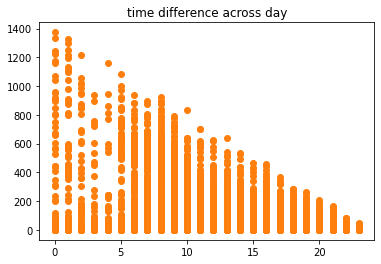

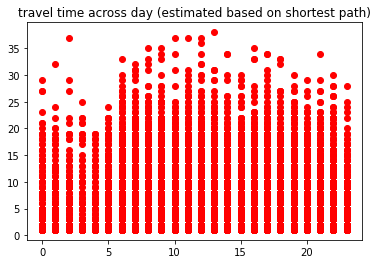

In [8]:
#convert data with estimated shortest path info
file_path = 'G:/My Drive/2021/Bias/census_tract_process/crossed_routes.csv'
crossed_rt = pd.read_csv(file_path)

get_hr = lambda x: datetime.fromtimestamp(x).hour
get_minute = lambda x: datetime.fromtimestamp(x).minute
crossed_rt['s_hr'] = crossed_rt['start_time'].apply(get_hr).values
crossed_rt['e_hr'] = crossed_rt['end_time'].apply(get_hr).values
crossed_rt['s_min'] = crossed_rt['start_time'].apply(get_minute).values
crossed_rt['e_min'] = crossed_rt['end_time'].apply(get_minute).values

to5min = lambda x: int(x/5)*5
crossed_rt['s_minut_5'] = crossed_rt['s_min'].apply(to5min)
crossed_rt['e_minut_5'] = crossed_rt['e_min'].apply(to5min)

get_timeloct_id = lambda x: str(x)+'_'
remove_last_symbol = lambda x: x[:-1]
crossed_rt['ori_st'] = (crossed_rt['new_ori'].apply(get_timeloct_id)+\
crossed_rt['s_hr'].apply(get_timeloct_id)+\
crossed_rt['s_minut_5'].apply(get_timeloct_id)).apply(remove_last_symbol)

crossed_rt['dest_st'] = (crossed_rt['new_dest'].apply(get_timeloct_id)+\
crossed_rt['e_hr'].apply(get_timeloct_id)+\
crossed_rt['e_minut_5'].apply(get_timeloct_id)).apply(remove_last_symbol)

crossed_rt = crossed_rt[crossed_rt.columns[5:]]
crossed_rt.columns


### sparse svd
#predsvd_rmse_s, lfsvd_rmse_s, rmse_svd_s = get_best_svd(test_matrice_scaled_reverse, False)
#predsvd_rmse, lfsvd_rmse, rmse_svd = get_best_svd(test_matrice_reverse, False)

#nmf_rmse_dict, nmf_zero_score, nmf_mae_dict, nmf_rmse_w0, nmf_mae_w0 = get_best_NMFwzero(test_matrice_reverse, Zero_index)


#get neighborhood census tract info
os.chdir('G:/My Drive/2021/Bias/census_tract_process')
pathfile = 'G:/My Drive/2021/Bias/census_tract_process/'
Seattle_ct = pd.read_csv(pathfile+'Seattle_ct.csv')
Seattle_ct.columns
Seattle_ct = Seattle_ct[['GEOID10','Nb_interse', 'nb_count', 'nb_touch', 'nb_bf_5', 'nb_bf10', \
                         'nb_bf100','nb_bf1mi','Area', 'Distance m','Distance_1', 'field_1', 'index']]

#check time difference change for each individual
newids = list(newids_map.keys())
a = 0
index = 0
for ids in newids:
    if a <= index:
        test_dt = crossed_rt[['time_diff', 'travel_time','s_hr','e_hr','od_euqal']][crossed_rt['newid'] == ids]
        test_dt = test_dt.sort_values(by=['time_diff'])
        plt.figure(a)
        x = list(test_dt['s_hr'].values)
        y = list(test_dt['time_diff'].values)
        plt.plot(x,y,'o')
        plt.title('time difference between each time segement for ids = '+str(ids))
        a += 1
        
test_dt = crossed_rt[['s_hr', 'time_diff', 'travel_time']][crossed_rt['od_euqal']==0].sort_values(by=['s_hr', 'time_diff'])
plt.figure(0)
plt.plot(list(test_dt['s_hr'].values), list(test_dt['time_diff'].values),'o')
plt.title('time difference across day')
plt.figure(1)
plt.plot(list(test_dt['s_hr'].values), list(test_dt['travel_time'].values),'ro')
plt.title('travel time across day (estimated based on shortest path)')

#keep previous census tract
ori_geo = crossed_rt['ori_geo'].values
dest_geo = crossed_rt['dest_geo'].values
no_crossed_ct = crossed_rt['no_crossed_ct'].values
no_crossed_cts = []
for i in range(len(ori_geo)):
    no_crossed = no_crossed_ct[i].strip('[]').split(', ')
    if str(ori_geo[i]) in no_crossed:
        no_crossed.remove(str(ori_geo[i]))
    if str(dest_geo[i]) in no_crossed:
        no_crossed.remove(str(dest_geo[i]))
    no_crossed_cts.append(no_crossed)

del(ori_geo)
del(dest_geo)
del(no_crossed_ct)

crossed_rt['no_crossedcts'] = no_crossed_cts
crossed_rt = crossed_rt.sort_values(by=['newid','time_diff','s_hr'])


#we found missing valeues after we processing the data
#latlon_path = 'G:/My Drive/2021/Bias/data-processing/'
Seattle_latlon = pd.read_csv('Seattle_latlon.csv', index_col=0)

selected_colname = list(Seattle_latlon.columns)
selected_colname.remove('Unnamed: 0.1')
Seattle_latlon = Seattle_latlon[selected_colname]
Seattle_latlon['minut_5'] = (Seattle_latlon['minut'].apply(to5min)).values
#through the checking, it is found there are individuals missing after the shortest path algorithm
ids_in_dt = list(np.unique(crossed_rt['newid']))
diff = set(newids)^set(ids_in_dt)

print('# of ids with shortest path: ', len(ids_in_dt))
print('# of identified ids: ', len(newids_map.keys()))
print('# of missing ids without shortest path: ', len(diff))

#check the missed data in detail

crossed_rt = crossed_rt.sort_values(by=['newid','start_time'])
crossed_rt.reset_index(inplace=True)
crossed_rt.head(3)

newids = np.unique(crossed_rt['newid'])
kept_data_start = {}
kept_data_end = {}
for ids in newids:
    kept_data_start[ids] = list(crossed_rt['start_time'][crossed_rt['newid']==ids].values)
    kept_data_end[ids] = list(crossed_rt['end_time'][crossed_rt['newid']==ids].values)
    
#get missing trips
#missing ids with missing data
newids = np.unique(crossed_rt['newid'])
newids_all = list(newids_map.keys())
missing_ids = {}
for ids in newids_all:
    missing_ids[ids] = []
    time_data = list(Seattle_latlon['timestamp'][Seattle_latlon['newid']==ids].values)
    if ids not in newids:
        missing_ids[ids] = time_data
    else:    
        for time in time_data:
            if time not in kept_data_end[ids] and time not in kept_data_start[ids]:
                missing_ids[ids].append(time)
                
missing_pairs = {}
for ids in newids:
    missing_pairs[ids] = {'o':[],'d':[]}
    cur_odpairs = crossed_rt[['start_time', 'end_time']][crossed_rt['newid']==ids].values
    time_data = list(Seattle_latlon['timestamp'][Seattle_latlon['newid']==ids].values)
    for i in range(len(time_data)):
        if i < len(time_data)-1:
            od_pairs = []
            od_pairs.append(time_data[i]) 
            od_pairs.append(time_data[i+1])
            if od_pairs not in cur_odpairs:
                missing_pairs[ids]['o'].append(od_pairs[0])
                missing_pairs[ids]['d'].append(od_pairs[1]) 
                
                
print('worst data accuracy: ', np.max(Seattle_latlon['accuracy']))

census_t = list(np.unique(Seattle_latlon['GEOID10']))

zero_loc_time = {}
for ids in missing_ids:
    if ids not in zero_loc_time:
        zero_loc_time[ids] = []
    zero_loc_time[ids] = convert_missingids(missing_ids[ids], ids, zero_loc_time[ids])
    
# create the zero index matrix
Zero_index = np.zeros(test_matrice_reverse[:, 1:].shape)
for row in zero_loc_time:
    for col in zero_loc_time[row]:
        Zero_index[newids_map[row]][locts_map[col]] = 1

In [5]:
import numbers
import scipy.sparse as sp
import warnings
from math import sqrt
import time

from sklearn.decomposition._cdnmf_fast import _update_cdnmf_fast #not able to be revised, visual studio version not matched
from sklearn._config import config_context
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import randomized_svd, safe_sparse_dot, squared_norm
from sklearn.utils.validation import check_is_fitted, check_non_negative
#code reference https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09bcc2eaeba98f7e737aac2ac782f0e5f1/sklearn/decomposition/_nmf.py

In [2]:
EPSILON = np.finfo(np.float32).eps

def norm(x):
    return sqrt(squared_norm(x))


def trace_dot(X, Y):
    return np.dot(X.ravel(), Y.ravel())


def _check_init(A, shape, whom):
    A = check_array(A)
    if np.shape(A) != shape:
        raise ValueError(
            "Array with wrong shape passed to %s. Expected %s, but got %s "
            % (whom, shape, np.shape(A))
        )
    check_non_negative(A, whom)
    if np.max(A) == 0:
        raise ValueError("Array passed to %s is full of zeros." % whom)
        
def _beta_divergence(X, W, H, beta, square_root=False):
    beta = _beta_loss_to_float(beta)

    # The method can be called with scalars
    if not sp.issparse(X):
        X = np.atleast_2d(X)
    W = np.atleast_2d(W)
    H = np.atleast_2d(H)

    # Frobenius norm
    if beta == 2:
        # Avoid the creation of the dense np.dot(W, H) if X is sparse.
        if sp.issparse(X):
            norm_X = np.dot(X.data, X.data)
            norm_WH = trace_dot(np.linalg.multi_dot([W.T, W, H]), H)
            cross_prod = trace_dot((X * H.T), W)
            res = (norm_X + norm_WH - 2.0 * cross_prod) / 2.0
        else:
            res = squared_norm(X - np.dot(W, H)) / 2.0

        if square_root:
            return np.sqrt(res * 2)
        else:
            return res

    if sp.issparse(X):
        # compute np.dot(W, H) only where X is nonzero
        WH_data = _special_sparse_dot(W, H, X).data
        X_data = X.data
    else:
        WH = np.dot(W, H)
        WH_data = WH.ravel()
        X_data = X.ravel()

    # do not affect the zeros: here 0 ** (-1) = 0 and not infinity
    indices = X_data > EPSILON
    WH_data = WH_data[indices]
    X_data = X_data[indices]

    # used to avoid division by zero
    WH_data[WH_data == 0] = EPSILON

    # generalized Kullback-Leibler divergence
    if beta == 1:
        # fast and memory efficient computation of np.sum(np.dot(W, H))
        sum_WH = np.dot(np.sum(W, axis=0), np.sum(H, axis=1))
        # computes np.sum(X * log(X / WH)) only where X is nonzero
        div = X_data / WH_data
        res = np.dot(X_data, np.log(div))
        # add full np.sum(np.dot(W, H)) - np.sum(X)
        res += sum_WH - X_data.sum()

    # Itakura-Saito divergence
    elif beta == 0:
        div = X_data / WH_data
        res = np.sum(div) - np.product(X.shape) - np.sum(np.log(div))

    # beta-divergence, beta not in (0, 1, 2)
    else:
        if sp.issparse(X):
            # slow loop, but memory efficient computation of :
            # np.sum(np.dot(W, H) ** beta)
            sum_WH_beta = 0
            for i in range(X.shape[1]):
                sum_WH_beta += np.sum(np.dot(W, H[:, i]) ** beta)

        else:
            sum_WH_beta = np.sum(WH ** beta)

        sum_X_WH = np.dot(X_data, WH_data ** (beta - 1))
        res = (X_data ** beta).sum() - beta * sum_X_WH
        res += sum_WH_beta * (beta - 1)
        res /= beta * (beta - 1)

    if square_root:
        return np.sqrt(2 * res)
    else:
        return res


def _special_sparse_dot(W, H, X):
    if sp.issparse(X):
        ii, jj = X.nonzero()
        n_vals = ii.shape[0]
        dot_vals = np.empty(n_vals)
        n_components = W.shape[1]

        batch_size = max(n_components, n_vals // n_components)
        for start in range(0, n_vals, batch_size):
            batch = slice(start, start + batch_size)
            dot_vals[batch] = np.multiply(W[ii[batch], :], H.T[jj[batch], :]).sum(
                axis=1
            )

        WH = sp.coo_matrix((dot_vals, (ii, jj)), shape=X.shape)
        return WH.tocsr()
    else:
        return np.dot(W, H)


def _compute_regularization(alpha, alpha_W, alpha_H, l1_ratio, regularization):
    if alpha_W != 0 or alpha_H != "same":
        # if alpha_W or alpha_H is not left to its default value we ignore alpha and
        # regularization.
        alpha_H = alpha_W if alpha_H == "same" else alpha_H
        l1_reg_W = alpha_W * l1_ratio
        l1_reg_H = alpha_H * l1_ratio
        l2_reg_W = alpha_W * (1.0 - l1_ratio)
        l2_reg_H = alpha_H * (1.0 - l1_ratio)
    else:
        # TODO remove in 1.2
        l1_reg_W, l2_reg_W, l1_reg_H, l2_reg_H = 0.0, 0.0, 0.0, 0.0
        if regularization in ("both", "transformation"):
            l1_reg_W = alpha * l1_ratio
            l2_reg_W = alpha * (1.0 - l1_ratio)
        if regularization in ("both", "components"):
            l1_reg_H = alpha * l1_ratio
            l2_reg_H = alpha * (1.0 - l1_ratio)

    return l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H


def _beta_loss_to_float(beta_loss):
    """Convert string beta_loss to float."""
    allowed_beta_loss = {"frobenius": 2, "kullback-leibler": 1, "itakura-saito": 0}
    if isinstance(beta_loss, str) and beta_loss in allowed_beta_loss:
        beta_loss = allowed_beta_loss[beta_loss]

    if not isinstance(beta_loss, numbers.Number):
        raise ValueError(
            "Invalid beta_loss parameter: got %r instead of one of %r, or a float."
            % (beta_loss, allowed_beta_loss.keys())
        )
    return beta_loss


def _initialize_nmf(X, n_components, init="warn", eps=1e-6, random_state=None):
    """Algorithms for NMF initialization.
    Computes an initial guess for the non-negative
    rank k matrix approximation for X: X = WH.
    """
    if init == "warn":
        warnings.warn(
            "The 'init' value, when 'init=None' and "
            "n_components is less than n_samples and "
            "n_features, will be changed from 'nndsvd' to "
            "'nndsvda' in 1.1 (renaming of 0.26).",
            FutureWarning,
        )
        init = None

    check_non_negative(X, "NMF initialization")
    n_samples, n_features = X.shape

    if (
        init is not None
        and init != "random"
        and n_components > min(n_samples, n_features)
    ):
        raise ValueError(
            "init = '{}' can only be used when "
            "n_components <= min(n_samples, n_features)".format(init)
        )

    if init is None:
        if n_components <= min(n_samples, n_features):
            init = "nndsvd"
        else:
            init = "random"

    # Random initialization
    if init == "random":
        avg = np.sqrt(X.mean() / n_components)
        rng = check_random_state(random_state)
        H = avg * rng.randn(n_components, n_features).astype(X.dtype, copy=False)
        W = avg * rng.randn(n_samples, n_components).astype(X.dtype, copy=False)
        np.abs(H, out=H)
        np.abs(W, out=W)
        return W, H

    # NNDSVD initialization
    U, S, V = randomized_svd(X, n_components, random_state=random_state)
    W = np.zeros_like(U)
    H = np.zeros_like(V)

    # The leading singular triplet is non-negative
    # so it can be used as is for initialization.
    W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
    H[0, :] = np.sqrt(S[0]) * np.abs(V[0, :])

    for j in range(1, n_components):
        x, y = U[:, j], V[j, :]

        # extract positive and negative parts of column vectors
        x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
        x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

        # and their norms
        x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
        x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

        m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

        # choose update
        if m_p > m_n:
            u = x_p / x_p_nrm
            v = y_p / y_p_nrm
            sigma = m_p
        else:
            u = x_n / x_n_nrm
            v = y_n / y_n_nrm
            sigma = m_n

        lbd = np.sqrt(S[j] * sigma)
        W[:, j] = lbd * u
        H[j, :] = lbd * v

    W[W < eps] = 0
    H[H < eps] = 0

    if init == "nndsvd":
        pass
    elif init == "nndsvda":
        avg = X.mean()
        W[W == 0] = avg
        H[H == 0] = avg
    elif init == "nndsvdar":
        rng = check_random_state(random_state)
        avg = X.mean()
        W[W == 0] = abs(avg * rng.randn(len(W[W == 0])) / 100)
        H[H == 0] = abs(avg * rng.randn(len(H[H == 0])) / 100)
    else:
        raise ValueError(
            "Invalid init parameter: got %r instead of one of %r"
            % (init, (None, "random", "nndsvd", "nndsvda", "nndsvdar"))
        )

    return W, H


def _update_coordinate_descent(X, W, Ht, l1_reg, l2_reg, shuffle, random_state):
    """Helper function for _fit_coordinate_descent.
    Update W to minimize the objective function, iterating once over all
    coordinates. By symmetry, to update H, one can call
    _update_coordinate_descent(X.T, Ht, W, ...).
    """
    n_components = Ht.shape[1]

    HHt = np.dot(Ht.T, Ht)
    XHt = safe_sparse_dot(X, Ht)

    # L2 regularization corresponds to increase of the diagonal of HHt
    if l2_reg != 0.0:
        # adds l2_reg only on the diagonal
        HHt.flat[:: n_components + 1] += l2_reg
    # L1 regularization corresponds to decrease of each element of XHt
    if l1_reg != 0.0:
        XHt -= l1_reg

    if shuffle:
        permutation = random_state.permutation(n_components)
    else:
        permutation = np.arange(n_components)
    # The following seems to be required on 64-bit Windows w/ Python 3.5.
    permutation = np.asarray(permutation, dtype=np.intp)
    return _update_cdnmf_fast(W, HHt, XHt, permutation)


def _fit_coordinate_descent(
    X,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
    shuffle=False,
    random_state=None,
):
    """Compute Non-negative Matrix Factorization (NMF) with Coordinate Descent
    The objective function is minimized with an alternating minimization of W
    and H. Each minimization is done with a cyclic (up to a permutation of the
    features) Coordinate Descent.
    """
    # so W and Ht are both in C order in memory
    Ht = check_array(H.T, order="C")
    X = check_array(X, accept_sparse="csr")

    rng = check_random_state(random_state)

    for n_iter in range(1, max_iter + 1):
        violation = 0.0

        # Update W
        violation += _update_coordinate_descent(
            X, W, Ht, l1_reg_W, l2_reg_W, shuffle, rng
        )
        # Update H
        if update_H:
            violation += _update_coordinate_descent(
                X.T, Ht, W, l1_reg_H, l2_reg_H, shuffle, rng
            )

        if n_iter == 1:
            violation_init = violation

        if violation_init == 0:
            break

        if verbose:
            print("violation:", violation / violation_init)

        if violation / violation_init <= tol:
            if verbose:
                print("Converged at iteration", n_iter + 1)
            break
    #print(violation)

    return W, Ht.T, n_iter


def _multiplicative_update_w(
    X,
    W,
    H,
    beta_loss,
    l1_reg_W,
    l2_reg_W,
    gamma,
    H_sum=None,
    HHt=None,
    XHt=None,
    update_H=True,
):
    """Update W in Multiplicative Update NMF."""
    if beta_loss == 2:
        # Numerator
        if XHt is None:
            XHt = safe_sparse_dot(X, H.T)
        if update_H:
            # avoid a copy of XHt, which will be re-computed (update_H=True)
            numerator = XHt
        else:
            # preserve the XHt, which is not re-computed (update_H=False)
            numerator = XHt.copy()

        # Denominator
        if HHt is None:
            HHt = np.dot(H, H.T)
        denominator = np.dot(W, HHt)

    else:
        # Numerator
        # if X is sparse, compute WH only where X is non zero
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid taking a negative power of zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(X * (dot(W, H) ** (beta_loss - 2)), H.T)
        numerator = safe_sparse_dot(WH_safe_X, H.T)

        # Denominator
        if beta_loss == 1:
            if H_sum is None:
                H_sum = np.sum(H, axis=1)  # shape(n_components, )
            denominator = H_sum[np.newaxis, :]

        else:
            # computation of WHHt = dot(dot(W, H) ** beta_loss - 1, H.T)
            if sp.issparse(X):
                # memory efficient computation
                # (compute row by row, avoiding the dense matrix WH)
                WHHt = np.empty(W.shape)
                for i in range(X.shape[0]):
                    WHi = np.dot(W[i, :], H)
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WHHt[i, :] = np.dot(WHi, H.T)
            else:
                WH **= beta_loss - 1
                WHHt = np.dot(WH, H.T)
            denominator = WHHt

    # Add L1 and L2 regularization
    if l1_reg_W > 0:
        denominator += l1_reg_W
    if l2_reg_W > 0:
        denominator = denominator + l2_reg_W * W
    denominator[denominator == 0] = EPSILON

    numerator /= denominator
    delta_W = numerator

    # gamma is in ]0, 1]
    if gamma != 1:
        delta_W **= gamma

    return delta_W, H_sum, HHt, XHt


def _multiplicative_update_h(X, W, H, beta_loss, l1_reg_H, l2_reg_H, gamma):
    """Update H in Multiplicative Update NMF."""
    if beta_loss == 2:
        numerator = safe_sparse_dot(W.T, X)
        denominator = np.linalg.multi_dot([W.T, W, H])

    else:
        # Numerator
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid division by zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(W.T, (dot(W, H) ** (beta_loss - 2)) * X)
        numerator = safe_sparse_dot(W.T, WH_safe_X)

        # Denominator
        if beta_loss == 1:
            W_sum = np.sum(W, axis=0)  # shape(n_components, )
            W_sum[W_sum == 0] = 1.0
            denominator = W_sum[:, np.newaxis]

        # beta_loss not in (1, 2)
        else:
            # computation of WtWH = dot(W.T, dot(W, H) ** beta_loss - 1)
            if sp.issparse(X):
                # memory efficient computation
                # (compute column by column, avoiding the dense matrix WH)
                WtWH = np.empty(H.shape)
                for i in range(X.shape[1]):
                    WHi = np.dot(W, H[:, i])
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WtWH[:, i] = np.dot(W.T, WHi)
            else:
                WH **= beta_loss - 1
                WtWH = np.dot(W.T, WH)
            denominator = WtWH

    # Add L1 and L2 regularization
    if l1_reg_H > 0:
        denominator += l1_reg_H
    if l2_reg_H > 0:
        denominator = denominator + l2_reg_H * H
    denominator[denominator == 0] = EPSILON

    numerator /= denominator
    delta_H = numerator

    # gamma is in ]0, 1]
    if gamma != 1:
        delta_H **= gamma

    return delta_H


def _fit_multiplicative_update(
    X,
    W,
    H,
    beta_loss="frobenius",
    max_iter=200,
    tol=1e-4,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
):
    """Compute Non-negative Matrix Factorization with Multiplicative Update.
    The objective function is _beta_divergence(X, WH) and is minimized with an
    alternating minimization of W and H. Each minimization is done with a
    Multiplicative Update.
    
    """
    start_time = time.time()

    beta_loss = _beta_loss_to_float(beta_loss)

    # gamma for Maximization-Minimization (MM) algorithm [Fevotte 2011]
    if beta_loss < 1:
        gamma = 1.0 / (2.0 - beta_loss)
    elif beta_loss > 2:
        gamma = 1.0 / (beta_loss - 1.0)
    else:
        gamma = 1.0

    # used for the convergence criterion
    error_at_init = _beta_divergence(X, W, H, beta_loss, square_root=True)
    previous_error = error_at_init

    H_sum, HHt, XHt = None, None, None
    for n_iter in range(1, max_iter + 1):
        # update W
        # H_sum, HHt and XHt are saved and reused if not update_H
        delta_W, H_sum, HHt, XHt = _multiplicative_update_w(
            X, W, H, beta_loss, l1_reg_W, l2_reg_W, gamma, H_sum, HHt, XHt, update_H
        )
        W *= delta_W

        # necessary for stability with beta_loss < 1
        if beta_loss < 1:
            W[W < np.finfo(np.float64).eps] = 0.0

        # update H
        if update_H:
            delta_H = _multiplicative_update_h(
                X, W, H, beta_loss, l1_reg_H, l2_reg_H, gamma
            )
            H *= delta_H

            # These values will be recomputed since H changed
            H_sum, HHt, XHt = None, None, None

            # necessary for stability with beta_loss < 1
            if beta_loss <= 1:
                H[H < np.finfo(np.float64).eps] = 0.0

        # test convergence criterion every 10 iterations
        if tol > 0 and n_iter % 10 == 0:
            error = _beta_divergence(X, W, H, beta_loss, square_root=True)

            if verbose:
                iter_time = time.time()
                print(
                    "Epoch %02d reached after %.3f seconds, error: %f"
                    % (n_iter, iter_time - start_time, error)
                )

            if (previous_error - error) / error_at_init < tol:
                break
            previous_error = error

    # do not print if we have already printed in the convergence test
    if verbose and (tol == 0 or n_iter % 10 != 0):
        end_time = time.time()
        print(
            "Epoch %02d reached after %.3f seconds." % (n_iter, end_time - start_time)
        )

    return W, H, n_iter


def non_negative_factorization_w0(
    X,
    ZERO,
    W=None,
    H=None,
    n_components=None,
    *,
    init="warn",
    update_H=True,
    solver="cd",
    beta_loss="frobenius",
    tol=1e-4,
    max_iter=200,
    alpha="deprecated",
    alpha_W=0.0,
    alpha_H="same",
    l1_ratio=0.0,
    regularization="deprecated",
    random_state=None,
    verbose=0,
    shuffle=False,
):
    """Compute Non-negative Matrix Factorization (NMF).
    Find two non-negative matrices (W, H) whose product approximates the non-
    negative matrix X. This factorization can be used for example for
    dimensionality reduction, source separation or topic extraction.
   
    """
    X = check_array(X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32])
    
    if type(ZERO) != int:
        zero_reg = ZEROS
    else:
        zero_reg = 0
    
    est = NMF_w0(
        n_components=n_components,
        init=init,
        solver=solver,
        beta_loss=beta_loss,
        tol=tol,
        max_iter=max_iter,
        random_state=random_state,
        alpha=alpha,
        alpha_W=alpha_W,
        alpha_H=alpha_H,
        l1_ratio=l1_ratio,
        verbose=verbose,
        shuffle=shuffle,
        regularization=regularization,
        zero_weight=zero_weight,
    )

    with config_context(assume_finite=True):
        W, H, n_iter = est._fit_transform_w0(X, zero_reg, W=W, H=H, update_H=update_H)

    return W, H, n_iter

def check_nan(matrix, var):
    if True in np.isnan(matrix):
        print('nan in '+var)
        return(1)
    else:
        pass

def revise_nan(matrix):
    matrix[np.isnan(matrix)==True] = 0
    
def check_inf(matrix, var):
    if True in np.isinf(matrix):
        print('inf in '+var)
        return(1)
    else:
        pass
    
def check_non_zero(matrix, zero_index):
    if np.count_nonzero(zero_index) == 0:
        if np.count_nonzero(matrix) != 0:
            print('Warning, zero matrix return non zero')

def obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    zero_weight,
    l1_reg_W,
    l1_reg_H,
    l2_reg_W,
    l2_reg_H,
):
    obj = 0.5*np.linalg.norm(X-np.dot(W, H))
    if l1_reg_W != 0:
        obj += l1_reg_W*np.linalg.norm(W.flatten(order="F"), 1)
    else:
        pass
        
    if l1_reg_H != 0:
        obj += l1_reg_H*np.linalg.norm(H.flatten(order="F"), 1)
    else:
        pass
        
    if l2_reg_W != 0:
        obj += l2_reg_W*np.linalg.norm(W)
    else:
        pass
        
    if l2_reg_H != 0:
        obj += l2_reg_H*np.linalg.norm(H)
    else:
        pass
        
    if zero_weight != 0:
        obj += zero_weight*np.linalg.norm((np.multiply(np.dot(W, H), zero_reg)-np.zeros(X.shape)))
    else:
        pass
        
    return(obj)

def _gradient_update_w(
    X,
    zero_reg,
    W,
    H,
    l1_reg_W,
    l2_reg_W,
    zero_weight=0.0,
    HHt=None,
    XHt=None,
    update_H=True,
):
    """Update W in Multiplicative Update NMF."""
    #print('X', X.shape)
    #print('zero index', zero_reg.shape)
    #print('W', W.shape)
    #print('H', H.shape)
    if type(zero_reg) != int:
        zero_matrix = np.zeros(X.shape)
        
    # Numerator
    if XHt is None:
        XHt = safe_sparse_dot(X, H.T)
    #if update_H:
        # avoid a copy of XHt, which will be re-computed (update_H=True)
     #   numerator = XHt
    #else:
        # preserve the XHt, which is not re-computed (update_H=False)
    
    numerator = XHt.copy()
    #n_components = W.shape[1]
    
    # Denominator
    if HHt is None:
        HHt = np.dot(H, H.T)

    #Notice no need to add this since zero multiple anything would be zero still
    #if zero_weight != 0 and type(zero_reg) != int:
     #   numerator += zero_weight*np.dot(np.multiply(zero_matrix, zero_reg), H.T)
     #   check_non_zero(zero_weight*np.dot(np.multiply(zero_matrix, zero_reg), H.T), zero_reg)
        #check_nan(np.dot(np.multiply(zero_matrix, zero_reg), H.T),'numerator WHL')
        #check_inf(np.dot(np.multiply(zero_matrix, zero_reg), H.T),'numerator WHL')

    #if l2_reg_W != 0:
    #    numerator -= 2*l2_reg_W*np.dot(W, (np.dot(W.T, W)-np.identity(np.dot(W.T, W).shape[0])))
        #print('W, ', reg_constriant)
        #print(numerator)
        #del(WtW)
        #del(reg_constriant)
        #check_nan(numerator,'numerator l2')
        #check_inf(numerator,'numerator l2')

    #if l1_reg_W != 0:
    #    numerator -= l1_reg_W
        #check_nan(numerator, 'numerator l1')
        #check_inf(numerator, 'numerator l1')
    
    denominator = np.dot(W, HHt)
    if zero_weight != 0 and type(zero_reg) != int:
        denominator += zero_weight*np.dot(np.multiply(np.dot(W, H), zero_reg), H.T)
        check_non_zero(np.dot(np.multiply(np.dot(W, H), zero_reg), H.T), zero_reg)
    
    if l1_reg_W > 0:
        denominator += l1_reg_W
    if l2_reg_W > 0:
        denominator = denominator + l2_reg_W * W
        
    #revise_nan(denominator)
    denominator[denominator == 0] = EPSILON
    #check_inf(numerator, 'denominator')
    
    numerator /= denominator
    delta_W = numerator
    
    return delta_W, HHt, XHt


def _gradient_update_h(X, zero_reg, W, H, l1_reg_H, l2_reg_H, zero_weight):
    #print(zero_weight)
    
    numerator = np.dot(W.T, X).copy()
    #revise_nan(numerator)
    #n_components = W.shape[1]

    if type(zero_reg) != int:
        zero_matrix = np.zeros(X.shape)
    
    #zero matrix multiply anything would be zero, thus no need to add this part
    #if zero_weight != 0 and type(zero_reg) != int:
     #   numerator += zero_weight*np.dot(W.T, np.multiply(zero_matrix, zero_reg))
     #   check_non_zero(np.dot(W.T, np.multiply(zero_matrix, zero_reg)), zero_reg)
    
    #if l2_reg_H != 0:    
     #   numerator -= 2*l2_reg_H*np.dot(H, (np.dot(H.T, H)-np.identity(np.dot(H.T, H).shape[0])))
        #print('H, ', reg_constriant)
        #print(numerator)
        #del(HtH)
        #del(reg_constriant)
     #   check_nan(numerator,'l2')
     #   check_inf(numerator,'l2')

    #if l1_reg_H != 0:
    #    numerator -= l1_reg_H
    #    check_nan(numerator, 'l1')
    #    check_inf(numerator, 'l1')
    
    # Add L1 and L2 regularization
   # check_nan(W.T,'W.T')
   # check_nan(W,'W')
   # check_nan(H,'H')
    
   # check_inf(W.T,'W.T')
   # check_inf(W,'W')
   # check_inf(H,'H')
    
    denominator = np.linalg.multi_dot([W.T, W, H])
    if zero_weight != 0 and type(zero_reg) != int:
        denominator += zero_weight*np.dot(W.T,np.multiply(np.dot(W, H), zero_reg))
        check_non_zero(np.dot(W.T,np.multiply(np.dot(W, H), zero_reg)), zero_reg)

    if l1_reg_H > 0:
        denominator += l1_reg_H
    if l2_reg_H > 0:
        denominator = denominator + l2_reg_H * H
    denominator[denominator == 0] = EPSILON
    
   # check_nan(denominator,'denominator')
   # check_inf(denominator,'denominator')
    numerator /= denominator
    delta_H = numerator
    
   # check_nan(numerator,'numerator')
   # check_nan(delta_H,'delta H')
    
   # check_inf(numerator,'numerator')
   # check_inf(delta_H,'delta H')
    return delta_H

  
def _fit_gradient_descent_w0(
    X,
    zero_reg,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    zero_weight=0.0,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    random_state=None,
):
    # used for the convergence criterion
    error_at_init = obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    zero_weight,
    l1_reg_W,
    l1_reg_H,
    l2_reg_W,
    l2_reg_H,)

    #previous_error = error_at_init
    #current_error = 0
    
    HHt, XHt = None, None
    for n_iter in range(1, max_iter + 1):
        # update W
        # H_sum, HHt and XHt are saved and reused if not update_H
        
        #print('iter='+str(n_iter)+' W')
        
        delta_W, HHt, XHt = _gradient_update_w(
            X, zero_reg, W, H, l1_reg_W, l2_reg_W, zero_weight, HHt, XHt, update_H
        )
        
        W *= delta_W
        #check_nan(delta_W, 'update result delta W')
        #check_nan(W, 'update result W')
        
        # update H
        if update_H:
            #print('iter='+str(n_iter)+' H')
            delta_H = _gradient_update_h(
                X, zero_reg, W, H, l1_reg_H, l2_reg_H, zero_weight
            )
            H *= delta_H
            #check_nan(delta_H, 'update result delta H')
            #check_nan(H, 'update result H')
            
            # These values will be recomputed since H changed
            HHt, XHt = None, None
            
            #if tol > 0 and n_iter % 10 == 0:
            #    current_error = obj_loss_w0(X, zero_reg, W, H, zero_weight, l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)

            #if (previous_error - current_error) / error_at_init < tol:
            #    break
            
            #previous_error = current_error
    
    return W, H, n_iter

def zero_est_eval(est_matrix, zero_index, print_non_zero=False):
    zero_est = np.count_nonzero(np.round(np.multiply(np.round(est_matrix,0), zero_index),0))
    zero_est_index = 1 - zero_est/np.count_nonzero(zero_index)
    if print_non_zero == True:
        print(zero_est)
        return(zero_est, zero_est_index)
    else:
        return(zero_est_index)

def non_zero_est_eval(test_matrix, est_matrix, zero_index, withid=False):
    #delete estimated zeros
    if withid == True:
        test = test_matrix[:, 1:].copy() 
    else:
        test = test_matrix.copy()
        
    test = test - np.multiply(test, zero_index)
    est = est_matrix.copy()
    est = np.round(est - np.multiply(est, zero_index),0)
    rmse_ = cal_rmse(test, est, withids=False)
    mae_ = cal_mae(test, est, withids=False)
    
    return(rmse_, mae_)  


class NMF_w0(TransformerMixin, BaseEstimator):
    """Non-Negative Matrix Factorization (NMF).
    Find two non-negative matrices (W, H) whose product approximates the non-
    negative matrix X. This factorization can be used for example for
    dimensionality reduction, source separation or topic extraction.
    The objective function is:
    """

    def __init__(
        self,
        n_components=None,
        *,
        init="warn",
        solver="cd",
        beta_loss="frobenius",
        tol=1e-4,
        max_iter=200,
        random_state=None,
        alpha="deprecated",
        alpha_W=0.0,
        alpha_H="same",
        l1_ratio=0.0,
        verbose=0,
        shuffle=False,
        regularization="deprecated",
        zero_weight=0.0,
    ):
        self.n_components = n_components
        self.init = init
        self.solver = solver
        self.beta_loss = beta_loss
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.alpha = alpha
        self.alpha_W = alpha_W
        self.alpha_H = alpha_H
        self.l1_ratio = l1_ratio
        self.verbose = verbose
        self.shuffle = shuffle
        self.regularization = regularization
        self.zero_weight = zero_weight

    def _more_tags(self):
        return {"requires_positive_X": True}

    def _check_params(self, X):
        # n_components
        self._n_components = self.n_components
        if self._n_components is None:
            self._n_components = X.shape[1]
        if (
            not isinstance(self._n_components, numbers.Integral)
            or self._n_components <= 0
        ):
            raise ValueError(
                "Number of components must be a positive integer; got "
                f"(n_components={self._n_components!r})"
            )

        # max_iter
        if not isinstance(self.max_iter, numbers.Integral) or self.max_iter < 0:
            raise ValueError(
                "Maximum number of iterations must be a positive "
                f"integer; got (max_iter={self.max_iter!r})"
            )

        # tol
        if not isinstance(self.tol, numbers.Number) or self.tol < 0:
            raise ValueError(
                "Tolerance for stopping criteria must be positive; got "
                f"(tol={self.tol!r})"
            )

        # beta_loss
        self._beta_loss = _beta_loss_to_float(self.beta_loss)
        
        #obj_loss

        # solver
        allowed_solver = ("cd", "mu", "zero")
        if self.solver not in allowed_solver:
            raise ValueError(
                f"Invalid solver parameter: got {self.solver!r} instead of one of "
                f"{allowed_solver}"
            )
        if self.solver != "mu" and self.beta_loss not in (2, "frobenius"):
            # 'mu' is the only solver that handles other beta losses than 'frobenius'
            raise ValueError(
                f"Invalid beta_loss parameter: solver {self.solver!r} does not handle "
                f"beta_loss = {self.beta_loss!r}"
            )
        if self.solver == "mu" and self.init == "nndsvd":
            warnings.warn(
                "The multiplicative update ('mu') solver cannot update "
                "zeros present in the initialization, and so leads to "
                "poorer results when used jointly with init='nndsvd'. "
                "You may try init='nndsvda' or init='nndsvdar' instead.",
                UserWarning,
            )

        # alpha and regularization are deprecated in favor of alpha_W and alpha_H
        # TODO clean up in 1.2
        if self.alpha != "deprecated":
            warnings.warn(
                "`alpha` was deprecated in version 1.0 and will be removed "
                "in 1.2. Use `alpha_W` and `alpha_H` instead",
                FutureWarning,
            )
            alpha = self.alpha
        else:
            alpha = 0.0            

        if self.regularization != "deprecated":
            warnings.warn(
                "`regularization` was deprecated in version 1.0 and will be "
                "removed in 1.2. Use `alpha_W` and `alpha_H` instead",
                FutureWarning,
            )
            allowed_regularization = ("both", "components", "transformation", None)
            if self.regularization not in allowed_regularization:
                raise ValueError(
                    f"Invalid regularization parameter: got {self.regularization!r} "
                    f"instead of one of {allowed_regularization}"
                )
            regularization = self.regularization
        else:
            regularization = "both"

        (
            self._l1_reg_W,
            self._l1_reg_H,
            self._l2_reg_W,
            self._l2_reg_H,
        ) = _compute_regularization(
            alpha, self.alpha_W, self.alpha_H, self.l1_ratio, regularization
        )

        return self

    def _check_w_h(self, X, zero_reg, W, H, update_H):
        # check W and H, or initialize them
        n_samples, n_features = X.shape
        if self.init == "custom" and update_H:
            _check_init(H, (self._n_components, n_features), "NMF (input H)")
            _check_init(W, (n_samples, self._n_components), "NMF (input W)")
            if H.dtype != X.dtype or W.dtype != X.dtype:
                raise TypeError(
                    "H and W should have the same dtype as X. Got "
                    "H.dtype = {} and W.dtype = {}.".format(H.dtype, W.dtype)
                )
        elif not update_H:
            _check_init(H, (self._n_components, n_features), "NMF (input H)")
            if H.dtype != X.dtype:
                raise TypeError(
                    "H should have the same dtype as X. Got H.dtype = {}.".format(
                        H.dtype
                    )
                )
            # 'mu' solver should not be initialized by zeros
            if self.solver == "mu" or type(zero_reg) != int:
                avg = np.sqrt(X.mean() / self._n_components)
                W = np.full((n_samples, self._n_components), avg, dtype=X.dtype)
            else:
                W = np.zeros((n_samples, self._n_components), dtype=X.dtype)
        else:
            W, H = _initialize_nmf(
                X, self._n_components, init=self.init, random_state=self.random_state
            )
        return W, H

    def _scale_regularization(self, X):
        n_samples, n_features = X.shape
        if self.alpha_W != 0 or self.alpha_H != "same":
            # if alpha_W or alpha_H is not left to its default value we ignore alpha
            # and regularization, and we scale the regularization terms.
            l1_reg_W = n_features * self._l1_reg_W
            l1_reg_H = n_samples * self._l1_reg_H
            l2_reg_W = n_features * self._l2_reg_W
            l2_reg_H = n_samples * self._l2_reg_H
       # elif self.alpha != 0:
       #     l1_reg_W = n_features * self._l1_reg_W
       #     l1_reg_H = n_samples * self._l1_reg_H
       #     l2_reg_W = n_features * self._l2_reg_W
       #     l2_reg_H = n_samples * self._l2_reg_H
        else:
            # Otherwise we keep the old behavior with no scaling
            # TODO remove in 1.2
            l1_reg_W = self._l1_reg_W
            l1_reg_H = self._l1_reg_H
            l2_reg_W = self._l2_reg_W
            l2_reg_H = self._l2_reg_H

        return l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H

    def fit_transform_w0(self, X, zero_reg, y=None, W=None, H=None):
        """Learn a NMF model for the data X and returns the transformed data.
        This is more efficient than calling fit followed by transform.
        """
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32]
        )

        with config_context(assume_finite=True):
            W, H, n_iter = self._fit_transform_w0(X, zero_reg, W=W, H=H)

        self.reconstruction_err_ = _beta_divergence(
            X, W, H, self._beta_loss, square_root=True
        )

        self.n_components_ = H.shape[0]
        self.components_ = H
        self.n_iter_ = n_iter

        return W
    
    # w0 = with zero
    def _fit_transform_w0(self, X, zero_reg, y=None, W=None, H=None, update_H=True):
        """Learn a NMF model for the data X and returns the transformed data.
        """
        check_non_negative(X, "NMF (input X)")

        # check parameters
        self._check_params(X)

        if X.min() == 0 and self._beta_loss <= 0:
            raise ValueError(
                "When beta_loss <= 0 and X contains zeros, "
                "the solver may diverge. Please add small values "
                "to X, or use a positive beta_loss."
            )

        # initialize or check W and H
        W, H = self._check_w_h(X, zero_reg, W, H, update_H)

        # scale the regularization terms
        l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H = self._scale_regularization(X)
        
        #print(l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)
        
       # print(zero_reg)
       # if type(zero_reg) == int: #keep the original method when not considering the zero matrix
        if type(zero_reg) != int or self.solver == "zero":  
            #print('apply zero od method')
            W, H, n_iter = _fit_gradient_descent_w0(
                X,
                zero_reg,
                W,
                H,                
                self.tol,
                self.max_iter,
                self.zero_weight,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,                
            )
        elif self.solver == "cd":
            print('apply cd')
            W, H, n_iter = _fit_coordinate_descent(
                X,
                W,
                H,
                self.tol,
                self.max_iter,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H=update_H,
                verbose=self.verbose,
                shuffle=self.shuffle,
                random_state=self.random_state,
            )
        elif self.solver == "mu":
            print('apply mu')
            W, H, n_iter = _fit_multiplicative_update(
                X,
                W,
                H,
                self._beta_loss,
                self.max_iter,
                self.tol,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H=update_H,
                verbose=self.verbose,
            )
    #else: #add the zero constriants
        else:
            raise ValueError("Invalid solver parameter '%s'." % self.solver)

        '''if n_iter == self.max_iter and self.tol > 0:
            warnings.warn(
                "Maximum number of iterations %d reached. Increase "
                "it to improve convergence."
                % self.max_iter,
                ConvergenceWarning,
            )'''

        return W, H, n_iter

    def fit(self, X, y=None, **params):
        """Learn a NMF model for the data X.
        """
        self.fit_transform_w0(X, **params)
        return self

    def transform(self, X):
        """Transform the data X according to the fitted NMF model.
        """
        check_is_fitted(self)
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32], reset=False
        )

        with config_context(assume_finite=True):
            W, *_ = self._fit_transform_w0(X, zero_reg, H=self.components_, update_H=False)

        return W

    def inverse_transform(self, W):
        """Transform data back to its original space.
        """
        check_is_fitted(self)
        return np.dot(W, self.components_)



NameError: name 'TransformerMixin' is not defined

### Simple test

In [19]:
## simple test
zero_test = np.zeros(X.shape)
zero_test[0] += 1
zero_test[1][0] = 1

#model = NMF_w0(n_components=18, init='nndsvd', zero_weight=0.1, max_iter=10, alpha=0.1, l1_ratio=0.1, random_state=42)
#W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
#model = NMF_w0(n_components=2, alpha=0.1, max_iter=1000, l1_ratio=0.1, zero_weight=zero_w, solver="zero", random_state=42)
#W = model.fit_transform_w0(X, zero_test)
#H = model.components_
#WH = np.dot(W, H)
#print(cal_rmse(X, WH))
#print(cal_rmse(X, WH, withids=False))
#print(X)
#print(WH)

def add_val2lst(val, lst):
    if init == True:
        lst = []
    lst.append(val)
    return(lst)

zero_val = []
rmse_val = []
mae_val = []

print(zero_test)
print(X)

for zero_w in 0.1*np.array(list(range(10))):
    model = NMF_w0(n_components=2, alpha=0.1, max_iter=1000, l1_ratio=0.1, zero_weight=zero_w, solver="zero", random_state=42)
    W = model.fit_transform_w0(X, zero_test)
    H = model.components_
    WH = np.dot(W, H)
    
    print(WH)
    zero_val.append(zero_est_eval(WH, zero_test))
    rmse_test, mae_test = (non_zero_est_eval(X, WH, zero_test))
    rmse_val.append(rmse_test)
    mae_val.append(mae_test)

plt.figure(1)
plt.plot(rmse_val)
plt.ylabel("rmse")

plt.figure(2)
plt.plot(mae_val)
plt.ylabel("mae")
#notice that the results of model without zero index is the same for solver='zero' and solver='mu' (test verified)

NameError: name 'X' is not defined

In [7]:
#save matrice
#np.savetxt('test_matrice_reverse.csv', test_matrice_reverse, delimiter=",")
#np.savetxt('Zero_index.csv', Zero_index, delimiter=",")

#read the test matrice and data
test_matrice_reverse = pd.read_csv('test_matrice_reverse.csv', header=None).to_numpy()
Zero_index = pd.read_csv('Zero_index.csv', header=None).to_numpy()

In [ ]:
#read land use data
def read_dict(filepath):
    with open(filepath) as f:
        data = f.read()
    dict_data = ast.literal_eval(data)
    return(dict_data)

def convert_dict(index_dict):
    convertdict = {}
    for keys in index_dict:
        convertdict[index_dict[keys]] = keys
    return(convertdict)


row_index = read_dict('row_index.txt')
col_index = read_dict('col_index.txt')

user_index = convert_dict(row_index)
item_index = convert_dict(col_index)

Seattle_01obs = pd.read_csv('obs01_landuse.csv', header=None).to_numpy()
Seattle_obs = pd.read_csv('obs_landuse.csv', header=None).to_numpy()
Zero_index = pd.read_csv('zero_index_landuse.csv', header=None).to_numpy()

In [8]:
'''#sensitive test
test_lf = list(range(2, 50))

#for num_lf in test_lf:
#    for reg_l in l1:
#        for a in alpha_para:
def create_ss_dict(dict_):
    keys = ['zero', 'non_zero_num', 'rmse', 'mae']
    for i in keys:
        dict_[i] = []
    return(dict_)

def assign_val(ss_dict, val_lst):
    lst_range = len(val_lst)
    keys = list(ss_dict.keys())
    for i in range(lst_range):
        ss_dict[keys[i]].append(val_lst[i])
    return(ss_dict)
      
#plot zero index, non zero num, rmse, mae
def plot_est_result(dict_, x_range, x_label):
    keys = list(dict_.keys())
    
    for i in range(2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
        ax1.plot(x_range, ss_k[keys[2*i]])
        ax2.plot(x_range, ss_k[keys[2*i+1]])
        for ax in ax1, ax2:
            ax.grid(True)

        ax1.set_ylabel(keys[2*i])
        ax2.set_ylabel(keys[2*i+1])
        ax1.set_xlabel(x_label)
        ax2.set_xlabel(x_label)

def compare_plot(lst1, lst2, label1, label2, xrange, xlabel, ylabel):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ax1.plot(xrange, lst1)
    ax2.plot(xrange, lst2)
    ax3.plot(xrange, lst1, label = label1)
    ax3.plot(xrange, lst2, label = label2)
    ax3.legend()
    
    for ax in ax1, ax2, ax3:
        ax.grid(True)

    ax1.set_title(label1)
    ax2.set_title(label2)
    ax3.set_title(label1 + ' vs. ' + label2)
    ax1.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
      

def cal_diff_per(lst_combine):
    lst1, lst2 = lst_combine[0], lst_combine[1]
    per = list((np.array(lst1) - np.array(lst2))/(np.array(lst1)))
    return(per)

def plot_two_fig(lst1, lst2, label1, label2, xrange, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
    ax1.plot(xrange, lst1)
    ax2.plot(xrange, lst2)
    
    for ax in ax1, ax2, ax3:
        ax.grid(True)
        
    ax1.set_ylabel(label1)
    ax2.set_ylabel(label2)
    ax1.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    

def difference_plot(zero, non_zero_num, rmse, mae, xrange, xlabel):
    keys = ['zero', 'non_zero_num', 'rmse', 'mae']
    
    per_zero = cal_diff_per(zero)
    print(per_zero)
    per_non_zero_num = cal_diff_per(non_zero_num)
    per_rmse = cal_diff_per(rmse)
    per_mae = cal_diff_per(mae)
    
    plot_two_fig(per_zero, per_non_zero_num, keys[0], keys[1], xrange, xlabel)
    plot_two_fig(per_rmse, per_mae, keys[2], keys[3], xrange, xlabel)
'''        

In [ ]:
'''
#done in laptop
#sensitive test for k    
ss_k = create_ss_dict({})
for k in test_lf:
    dict_keys = 'k='+str(k)+', lambda=0, alpha=0, w0=0.1'
    start = time.time()
    model = NMF_w0(n_components=k, alpha=0, max_iter=1000, l1_ratio=0, random_state=42, zero_weight=0.1, init='nndsvd')
    W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    print(dict_keys)
    print(f'running time={end-start}')
    print(cal_rmse(test_matrice_reverse, WH))
    print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
    non_zero_num, zero_index  = zero_est_eval(WH, Zero_index, print_non_zero=True)
    rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
    ss_k = assign_val(ss_k, [zero_index, non_zero_num, rmse_, mae_])
    
#plot_result(ss_k)

ss_k_wo0 = create_ss_dict({})
for k in test_lf:
    dict_keys = 'k='+str(k)+', lambda=0, alpha=0, w0=0'
    start = time.time()
    model = NMF_w0(n_components=k, alpha=0, max_iter=1000, l1_ratio=0, random_state=42, \
                   zero_weight=0, init='nndsvd', solver='zero')
    W = model.fit_transform_w0(test_matrice_reverse[:, 1:], 0)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    print(dict_keys)
    print(f'running time={end-start}')
    print(cal_rmse(test_matrice_reverse, WH))
    print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
    non_zero_num, zero_index  = zero_est_eval(WH, Zero_index, print_non_zero=True)
    rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
    ss_k_wo0 = assign_val(ss_k_wo0, [zero_index, non_zero_num, rmse_, mae_])
    
#plot_result(ss_k_wo0)

#create csv to save model results
os.chdir('G:/My Drive/2021/Bias')
with open('nmf_est_result.txt', 'w') as f:
    f.write('model_with_zero, k, l1_ratio, alpha_w, alpha_h, zero_weight, max_iter, random_state, rmse, mae, zero_per, non_zero_num\n')
    rows = len(ss_k['zero'])
    dict_keys = list(ss_k.keys())
    
    for i in range(rows):
        writelines = '1,'+str(i+2)+',0,0,0,0.1,1000,42,'
        a = 0
        for dic_key in dict_keys:
            if a == 3:
                writelines = writelines+str(ss_k[dic_key][i])
                writelines = writelines+'\n'
            else:
                writelines = writelines+str(ss_k[dic_key][i])+','
            a += 1
        f.write(writelines)
            
#def save2text(pathfile, savename, write_content)

with open('nmf_est_result.txt', 'a') as f:
    rows = len(ss_k_wo0['zero'])
    dict_keys = list(ss_k_wo0.keys())
    
    for i in range(rows):
        writelines = '0,'+str(i+2)+',0,0,0,0,1000,42,'
        a = 0
        for dic_key in dict_keys:
            if a == 3:
                writelines = writelines+str(ss_k_wo0[dic_key][i])
                writelines = writelines+'\n'
            else:
                writelines = writelines+str(ss_k_wo0[dic_key][i])+','
            a += 1
        f.write(writelines)

f.close()
        '''

In [ ]:
'''#plot test
compare_plot(ss_k['non_zero_num'], ss_k_wo0['non_zero_num'], 'with zero index',\
             'w.o. index', range(2, 19), 'number of latent factor (k)', '# of missing estimated zeros')

difference_plot([ss_k_wo0['zero'],ss_k['zero']],
                [ss_k_wo0['non_zero_num'], ss_k['non_zero_num']],
                [ss_k_wo0['rmse'], ss_k['rmse']],
                [ss_k_wo0['mae'], ss_k['mae']],
                range(2,19),
                '# of latent factors (k)')

#initialization
cur_dict_keys = []
for k in range(2, 19):
    dict_key = 'zero_index='+'1, '+'k='+str(k)+', lambda=0.0, alpha_w=0.0, alpha_h=0.0, w0=0.1, max_iter=1000, random_state=42'
    cur_dict_keys.append(dict_key)
    dict_key = 'zero_index='+'0, '+'k='+str(k)+', lambda=0.0, alpha=0.0, w0=0.0, max_iter=1000, random_state=42'
    cur_dict_keys.append(dict_key)
    
    
#initialization
cur_dict_keys = []
for k in range(2, 19):
    dict_key = 'zero_index='+'1, '+'k='+str(k)+', lambda=0.0, alpha_w=0.0, alpha_h=0.0, w0=0.1, max_iter=1000, random_state=42'
    cur_dict_keys.append(dict_key)
    dict_key = 'zero_index='+'0, '+'k='+str(k)+', lambda=0.0, alpha=0.0, w0=0.0, max_iter=1000, random_state=42'
    cur_dict_keys.append(dict_key)
    
a = previous_resul.to_numpy()
a = a[:, :8]
np.isnan(np.nan)

#get all value
cur_dict_keys = []

def create_dict_key(val_lst):
    dict_key = ''
    dict_key = dict_key + 'zero_index='+str(int(val_lst[0]))+', '
    dict_key = dict_key + 'k='+str(int(val_lst[1]))+', '
    dict_key = dict_key + 'lambda='+str(val_lst[2])+', '
    if np.isnan(val_lst[3]) == True:
        dict_key = dict_key + 'alpha_w='+str(val_lst[4])+', '
    else:
        dict_key = dict_key + 'alpha_w='+str(val_lst[3])+', '
    dict_key = dict_key + 'alpha_h='+str(int(val_lst[4]))+', '
    dict_key = dict_key + 'w0='+str(val_lst[5])+', '
    dict_key = dict_key + 'max_iter='+str(int(val_lst[6]))+', '
    dict_key = dict_key + 'random_state='+str(int(val_lst[7]))
    return(dict_key)
                                                                                                           
def get_cur_dict_key(cur_dict_keys):
    previous_resul = pd.read_csv('nmf_est_result_cur.csv')
    param_val = previous_resul.to_numpy()
    param_val = param_val[:, :8]
    
    for val in param_val:
        dict_key = create_dict_key(val)
        if dict_key not in cur_dict_keys:
            cur_dict_keys.append(dict_key)
    return(cur_dict_keys)
    
cur_dict_keys = get_cur_dict_key(cur_dict_keys)'''

In [9]:
#parameter order
#zero index, k, lambda, alpha_w, alpha_h, w0, max_iter, random_state
params = ['zero_index', 'k', 'lambda', 'alpha_w', 'alpha_h', 'w0', 'max_iter', 'random_state']
def create_test_param_dict(parameter_lst, params):
    keys = list(range(8))
    parameter_dicts = {}
    for i in keys:
        parameter_dicts[params[i]] = parameter_lst[i]
    return(parameter_dicts)

def get_dict_keys(param_list, params, single_alpha):
    int_para = [0, 1, 6, 7]
    dict_keys = ''
    if len(param_list) != len(params):
        print('Error, wrong input paramter format, length not match')
    num_param = len(param_list)
    if single_alpha == False:
        for i in range(len(param_list)):
            if i != num_param-1:
                if i not in int_para:
                    dict_keys = dict_keys+params[i]+'='+str(param_list[i])+', '
                else:
                    dict_keys = dict_keys+params[i]+'='+str(int(param_list[i]))+', '
            else:
                dict_keys = dict_keys+params[i]+'='+str(int(param_list[i]))
    else:
        for i in range(len(param_list)):
            if i != num_param-1:
                if i not in int_para and i != 3:
                    dict_keys = dict_keys+params[i]+'='+str(param_list[i])+', '
                elif i == 3:
                    dict_keys = dict_keys+params[i]+'='+'NA'+', '
                else:
                    dict_keys = dict_keys+params[i]+'='+str(int(param_list[i]))+', '
            else:
                dict_keys = dict_keys+params[i]+'='+str(int(param_list[i]))
    return(dict_keys)
            
def writelines(paramlst, pathfile,single_alpha=False):
    num_param = len(paramlst)
    lines = ''
    if single_alpha == False:
        for i in range(num_param):
            if i < num_param-1:
                lines = lines + str(paramlst[i]) + ','
            else:
                lines = lines + str(paramlst[i]) + '\n'
    else:
        for i in range(num_param):
            if i < num_param-1 and i != 3:
                lines = lines + str(paramlst[i]) + ','
            elif i == 3:
                lines = lines + 'NA,'
            else:
                lines = lines + str(paramlst[i]) + '\n'
    with open(pathfile, 'a') as f:
        f.write(lines)  
    f.close()
        
def model_estimation(param_arr, test_matrice, zero_matrice, dict_keys, single_alpha = False):
    #['zero_index', 'k', 'lambda', 'alpha_w', 'alpha_h', 'w0', 'max_iter', 'random_state']
    print(param_arr)
    if type(param_arr) != list:
        param_list = param_arr.tolist()
    else:
        param_list = param_arr.copy()
    print(param_list)
    zero_index, k, l1, a_w, a_h, w0, iter_num, rand_seed = param_list
    start = time.time()
    if single_alpha == False:
        if int(zero_index) == 0:
            model = NMF_w0(n_components=int(k), alpha_W=a_w, alpha_H=a_h, max_iter=int(iter_num),\
                           l1_ratio=l1, random_state=int(rand_seed), zero_weight=w0, \
                           init='nndsvd', solver="zero")
            W = model.fit_transform_w0(test_matrice[:,1:], 0)
        else:
            model = NMF_w0(n_components=int(k), alpha_W=a_w, alpha_H=a_h, max_iter=int(iter_num),\
                           l1_ratio=l1, random_state=int(rand_seed), zero_weight=w0, \
                           init='nndsvd', solver="zero")
            W = model.fit_transform_w0(test_matrice[:,1:], zero_matrice)
    else:
        if int(zero_index) == 0:
            model = NMF_w0(n_components=int(k), alpha=a_h, max_iter=int(iter_num),\
                           l1_ratio=l1, random_state=int(rand_seed), zero_weight=w0, \
                           init='nndsvd', solver="zero")
            W = model.fit_transform_w0(test_matrice[:,1:], 0)
        else:
            model = NMF_w0(n_components=int(k), alpha=a_h, max_iter=int(iter_num),\
                           l1_ratio=l1, random_state=int(rand_seed), zero_weight=w0, \
                           init='nndsvd', solver="zero")
            W = model.fit_transform_w0(test_matrice[:,1:], zero_matrice)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    run_time = end-start
    print(dict_keys)
    print(f'running time={end-start}')
    #print(cal_rmse(test_matrice_reverse, WH))
    #print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    if True in np.isnan(WH):
        return(param_list)
    else:
        zero_index, non_zero_num = zero_est_eval(WH, zero_matrice, print_non_zero=True)
        rmse_, mae_ = non_zero_est_eval(test_matrice, WH, zero_matrice, withid=True)

    #print(param_list)
    #print(rmse_, mae_, zero_index, non_zero_num)
    
    #rmse, mae, zero_per, non_zero_num
    param_list.append(zero_index)
    param_list.append(non_zero_num)
    param_list.append(rmse_)
    param_list.append(mae_)
    param_list.append(run_time)
    #print(type(param_list))
    
    return(param_list)
    
        
def param_group_separate(test_parameter, 
                         params, 
                         test_parameters_dict,  
                         para_val, 
                         print_index=True):
    
    if len(test_parameter) > 0:
        combined_para_lst = []
        #test parameter separately
        for para in test_parameter:
            para_index = params.index(para)
            for vals in test_parameters_dict[para]:
                para_update = para_val.copy()
                para_update[para_index] = vals
                combined_para_lst.append(para_update)
        single_para = False
    else:
        combined_para_lst = para_val
        single_para = True
    if print_index == True:
        print(combined_para_lst)
    return(combined_para_lst, single_para)

def combine_2paras(lst1, lst2):
    unique_combinations = [] 
    permut = itertools.permutations(lst1, len(lst2))

    for comb in permut:
        zipped = zip(comb, lst2)
        unique_combinations.extend(list(zipped))
    return(list(set(unique_combinations)))

def get_repeat_num(val_len, index_num, divide_num, repeat_array):
    val_repeat = val_len.copy()
    val_repeat.pop(index_num)
    
    repeat_num = 1
    for num in val_repeat:
        repeat_num *= num
            
    new_arr = np.tile(np.repeat(repeat_array, repeat_num/divide_num), divide_num)
    
    divide_num *= val_len[index_num]
    return(new_arr, divide_num)

def param_combined(test_parameter, params, test_parameters_dict, para_val, print_index): 
    test_para_loc = []
    for test_para in test_parameter:
        index_loc = params.index(test_para)
        test_para_loc.append(index_loc)

        #get the index loc of each parameter
    num_test_para = len(test_para_loc)
    test_val = []
    for i in test_para_loc:
        test_val.append(test_parameters_dict[params[i]])

    #check length of the parameter
    val_len = []
    repeat_len = {}
    total_val = 1
    for i in range(num_test_para):
        num_var = len(test_val[i])
        val_len.append(num_var)
        total_val = total_val*num_var

    input_para = np.tile(para_val, (total_val, 1))
    input_para = input_para.astype(float)

    val_num = {}

    divide_num = 1
    for i in range(num_test_para):
        val_num[test_para_loc[i]], divide_num = get_repeat_num(val_len, i, divide_num, test_val[i])

    for i in range(num_test_para):
        input_para[:, test_para_loc[i]] = val_num[test_para_loc[i]]
    if print_index == True:
        print(input_para)
    
    single_para = False
    return(input_para, single_para)

def convert2lst(combined_set):
    revise_vals = combined_set
    #print(type(revise_vals[0]))
    
    if type(revise_vals[0]) is tuple:
        print('more than two eles applied')
        combined_lst = []
        while type(revise_vals[0]) not in [int, float]:
            combined_lst.insert(0, revise_vals[-1])
            revise_vals = revise_vals[0]
        combined_lst.insert(0, revise_vals)
    else:
        combined_lst = list(combined_set)
    return(combined_lst)


    combined_lst = []
    for ele in combined_p:
        para_cur = para_val.copy()
        for i in range(len(test_para_convert)):
            para_cur[test_para_convert[i]] = ele[i]
        combined_lst.append(para_cur)
        
    singla_para = False
    
    if print_index == True:
        print(combined_lst)
    
    return(combined_lst, singla_para)

def parameter_test(test_parameters_dict, 
                   params,
                   cur_dict_keys,
                   test_matrice, 
                   zero_matrice, 
                   savepath, 
                   combine_index = False,
                   print_index = True,
                   single_alpha = False):
    #get test param
    num_params = len(params)
    test_parameter = []

    #get and confirm the tested parameters
    for para_name in test_parameters_dict:
        if type(test_parameters_dict[para_name]) not in [int, float]:
            print('test paramters: '+para_name)
            test_parameter.append(para_name)
        
    #combine the parameter together
    para_val = []
    for i in range(num_params):
        if params[i] in test_parameter:
            para_val.append(0)
        else:
            para_val.append(test_parameters_dict[params[i]])
    #print(test_parameter)
    
    if combine_index == False:
        combined_para_lst, single_para = param_group_separate(test_parameter, params, 
                                                              test_parameters_dict, para_val, 
                                                              print_index)
    else:
        print(test_parameter)
        combined_para_lst, single_para = param_combined(test_parameter, params, 
                                                        test_parameters_dict, para_val, 
                                                        print_index)
                 
    if single_para == False:
        for param_list in combined_para_lst:
            #print(param_list)
            dict_keys = get_dict_keys(param_list, params, single_alpha)
            if dict_keys not in cur_dict_keys:
                cur_dict_keys.append(dict_keys)
                input_list = param_list.copy()
                output_list = model_estimation(input_list, test_matrice, zero_matrice, dict_keys, single_alpha)
                writelines(output_list, savepath, single_alpha)
    else:
        dict_keys = get_dict_keys(combined_para_lst, params, single_alpha)
        if dict_keys not in cur_dict_keys:
            cur_dict_keys.append(dict_keys)
            input_list = combined_para_lst.copy()
            output_list = model_estimation(input_list, test_matrice, zero_matrice, dict_keys, single_alpha)
            print(output_list)
            writelines(output_list, savepath, single_alpha)

In [55]:
#cur_dict_keys[-1]
#cur_dict_keys = cur_dict_keys[:-1]

In [11]:
l1 = np.round(0.1*np.array(list(range(10))),2)
alpha_para = np.round(0.1*np.array(list(range(10))),2)
zero_w = np.round(0.1*np.array(list(range(1,20))),2)
test_lf = list(range(2, 101))
#alpha_para

In [ ]:
cur_dict_keys = []
['zero_index', 'k', 'lambda', 'alpha_w', 'alpha_h', 'w0', 'max_iter', 'random_state']
w0_test_dict = create_test_param_dict([1, test_lf, 0, 0, 0, 0.1, 1000, 42], params)

parameter_test(w0_test_dict, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False)

In [ ]:
l_test_dict = create_test_param_dict([1, [9, 10], l1, 0, 0, zero_w, 1000, 42], params)

parameter_test(l_test_dict, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False)

In [75]:
alpha_test_dict = create_test_param_dict([1, [9, 10], 0.1, alpha_para, alpha_para, 0.1, 1000, 42], params)

parameter_test(alpha_test_dict, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False,
               single_alpha=True)

alpha_test_dict_wo0 = create_test_param_dict([0, [9, 10], 0.1, alpha_para, alpha_para, 0, 1000, 42], params)

parameter_test(alpha_test_dict_wo0, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False,
               single_alpha=True)

test paramters: k
test paramters: alpha_w
test paramters: alpha_h
['k', 'alpha_w', 'alpha_h']
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 0.0e+00 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.0, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.0, w0=0.1, max_iter=1000, random_state=42
running time=2007.9036984443665
617
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1719.3135039806366
613
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 2.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.2, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.2, w0=0.1, max_iter=1000, random_state=42
running time=1704.9622611999512
611
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 3.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.3, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.3, w0=0.1, max_iter=1000, random_state=42
running time=1702.869369506836
607
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 4.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.4, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.4, w0=0.1, max_iter=1000, random_state=42
running time=1703.5159747600555
605
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 5.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.5, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.5, w0=0.1, max_iter=1000, random_state=42
running time=1696.5696609020233
603
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 6.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.6, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.6, w0=0.1, max_iter=1000, random_state=42
running time=1743.4413990974426
601
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 7.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.7, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.7, w0=0.1, max_iter=1000, random_state=42
running time=1727.3280942440033
601
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 8.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.8, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.8, w0=0.1, max_iter=1000, random_state=42
running time=1705.1872465610504
598
[1.0e+00 9.0e+00 1.0e-01 0.0e+00 9.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.0, 0.9, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.9, w0=0.1, max_iter=1000, random_state=42
running time=1679.2617197036743
595
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 0.0e+00 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.0, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.0, w0=0.1, max_iter=1000, random_state=42
running time=1669.2274663448334
249
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1675.1884570121765
248
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 2.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.2, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.2, w0=0.1, max_iter=1000, random_state=42
running time=1686.6226601600647
248
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 3.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.3, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.3, w0=0.1, max_iter=1000, random_state=42
running time=1676.77188205719
247
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 4.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.4, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.4, w0=0.1, max_iter=1000, random_state=42
running time=1671.464002609253
247
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 5.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.5, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.5, w0=0.1, max_iter=1000, random_state=42
running time=1670.7298967838287
247
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 6.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.6, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.6, w0=0.1, max_iter=1000, random_state=42
running time=1673.2674038410187
247
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 7.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.7, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.7, w0=0.1, max_iter=1000, random_state=42
running time=1667.4469616413116
245
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 8.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.8, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.8, w0=0.1, max_iter=1000, random_state=42
running time=1671.9513757228851
245
[1.0e+00 1.0e+01 1.0e-01 0.0e+00 9.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.0, 0.9, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.9, w0=0.1, max_iter=1000, random_state=42
running time=1670.0058152675629
244
test paramters: k
test paramters: alpha_w
test paramters: alpha_h
['k', 'alpha_w', 'alpha_h']
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 0.0e+00 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.0, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.0, w0=0.0, max_iter=1000, random_state=42
running time=24.830163717269897
680
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 1.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.1, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.0, max_iter=1000, random_state=42
running time=24.962780714035034
678
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 2.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.2, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.2, w0=0.0, max_iter=1000, random_state=42
running time=24.78756356239319
678
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 3.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.3, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.3, w0=0.0, max_iter=1000, random_state=42
running time=25.101053476333618
677
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 4.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.4, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.4, w0=0.0, max_iter=1000, random_state=42
running time=25.1982524394989
673
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 5.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.5, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.5, w0=0.0, max_iter=1000, random_state=42
running time=24.925073385238647
672
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 6.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.6, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.6, w0=0.0, max_iter=1000, random_state=42
running time=24.750947952270508
672
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 7.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.7, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.7, w0=0.0, max_iter=1000, random_state=42
running time=25.14576292037964
669
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 8.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.8, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.8, w0=0.0, max_iter=1000, random_state=42
running time=24.899685382843018
664
[0.0e+00 9.0e+00 1.0e-01 0.0e+00 9.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 9.0, 0.1, 0.0, 0.9, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.9, w0=0.0, max_iter=1000, random_state=42
running time=26.503790855407715
664
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 0.0e+00 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.0, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.0, w0=0.0, max_iter=1000, random_state=42
running time=25.051746368408203
263
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 1.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.1, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.0, max_iter=1000, random_state=42
running time=25.723159074783325
262
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 2.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.2, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.2, w0=0.0, max_iter=1000, random_state=42
running time=26.752450704574585
261
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 3.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.3, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.3, w0=0.0, max_iter=1000, random_state=42
running time=25.692384958267212
261
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 4.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.4, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.4, w0=0.0, max_iter=1000, random_state=42
running time=25.59882164001465
260
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 5.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.5, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.5, w0=0.0, max_iter=1000, random_state=42
running time=25.738381385803223
260
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 6.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.6, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.6, w0=0.0, max_iter=1000, random_state=42
running time=25.744954586029053
258
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 7.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.7, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.7, w0=0.0, max_iter=1000, random_state=42
running time=26.053169012069702
257
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 8.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.8, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.8, w0=0.0, max_iter=1000, random_state=42
running time=25.7692711353302
257
[0.0e+00 1.0e+01 1.0e-01 0.0e+00 9.0e-01 0.0e+00 1.0e+03 4.2e+01]
[0.0, 10.0, 0.1, 0.0, 0.9, 0.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=0, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.9, w0=0.0, max_iter=1000, random_state=42
running time=25.840879917144775
256


In [29]:
k_val =np.array(list(range(2,101)))

In [30]:
alpha_test_dict_k1 = create_test_param_dict([1, k_val, 0.1, 0.1, 0.1, zero_w, 1000, 42], params)

In [32]:
alpha_test_dict_k2 = create_test_param_dict([0, k_val, 0.1, 0.1, 0.1, 0, 1000, 42], params)

In [ ]:
parameter_test(alpha_test_dict_k1, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False,
               single_alpha=True)

test paramters: k
test paramters: w0
['k', 'w0']
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1598.3923242092133
104
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1598.4193232059479
100
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1601.9850234985352
98
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1596.3004922866821
97
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1602.404224872589
93
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1600.4088101387024
91
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1598.486587524414
90
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1599.543871641159
87
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1598.5144295692444
87
[1.0e+00 2.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 2.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=2, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1596.253628730774
87
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1603.0043823719025
505
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1609.9363899230957
466
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1599.1648137569427
422
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1601.7704439163208
380
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1602.0001962184906
363
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1601.2182323932648
333
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1600.3485996723175
302
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1597.3403990268707
271
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1604.736894607544
252
[1.0e+00 3.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 3.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=3, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1603.8945775032043
236
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1842.780210018158
539
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1760.6463294029236
498
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1761.2350072860718
441
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1896.910970211029
397
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1852.9616923332214
361
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1838.8162956237793
331
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1954.1377911567688
285
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1970.039463043213
253
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1940.5364365577698
232
[1.0e+00 4.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 4.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=4, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1933.7974231243134
214
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1930.6231126785278
575
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1905.3364293575287
518
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1912.5990107059479
473
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1906.71710729599
420
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1920.2468860149384
378
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1898.9870524406433
342
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1894.9174273014069
300
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1892.5787510871887
261
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1906.0713150501251
238
[1.0e+00 5.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 5.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=5, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1831.4834084510803
218
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1797.4026155471802
591
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1722.4652345180511
527
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1707.294865846634
465
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1721.714370727539
407
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1708.8695228099823
351
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1709.4408180713654
315
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1722.9194860458374
269
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1711.9374601840973
238
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1709.4158124923706
216
[1.0e+00 6.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 6.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=6, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=2290.055324077606
197
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1999.8196649551392
590
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1777.175797700882
527
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1774.1598086357117
464
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1767.0340089797974
404
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1769.700530052185
356
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1766.2612464427948
324
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1761.4126806259155
272
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1762.8377766609192
245
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1756.6566643714905
223
[1.0e+00 7.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 7.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=7, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1754.1735439300537
200
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1742.9211049079895
594
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1713.9289371967316
530
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1732.9117186069489
466
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1710.1373023986816
406
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1731.0165548324585
355
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1726.2286758422852
325
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1728.8885278701782
274
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1734.020975112915
246
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1712.749852180481
224
[1.0e+00 8.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 8.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1728.0895447731018
200
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1721.665179491043
613
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1711.8639347553253
544
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1724.918441772461
488
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1720.3481976985931
418
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1715.7966792583466
366
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1727.414822101593
324
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1725.5364980697632
276
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1713.8119888305664
244
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=2303.6499586105347
226
[1.0e+00 9.0e+00 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 9.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=9, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1981.1536860466003
206
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1782.107486486435
248
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1795.6870076656342
235
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1768.9469361305237
221
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1779.3043122291565
217
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1765.967435836792
209
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1761.2346942424774
200
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1756.1203203201294
190
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1760.4698016643524
174
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1756.7643337249756
170
[1.0e+00 1.0e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 10.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=10, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1724.2390019893646
163
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1727.2827055454254
241
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1715.4610514640808
227
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1739.38827085495
218
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1722.5891437530518
215
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1736.1460089683533
203
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1735.995421886444
199
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1726.3986899852753
189
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1738.3830943107605
182
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1735.1147875785828
178
[1.0e+00 1.1e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 11.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=11, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1727.281389951706
174
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1738.6854190826416
258
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1732.1771309375763
244
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1730.1468172073364
235
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1738.466270685196
226
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1735.443119764328
214
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1727.1463618278503
205
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=2522.6462330818176
196
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1780.9621431827545
185
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1775.977187871933
181
[1.0e+00 1.2e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 12.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=12, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1772.4070630073547
176
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1768.1066229343414
259
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1761.586477279663
247
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1766.457796573639
240
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1759.8522384166718
232
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1759.8933718204498
217
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1755.5326929092407
208
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1770.2252869606018
200
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1731.9970982074738
192
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1726.663028717041
185
[1.0e+00 1.3e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 13.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=13, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1728.266872882843
183
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1731.75679063797
257
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1717.946772813797
247
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1731.3610169887543
239
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1714.8988778591156
233
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1734.1769790649414
217
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1732.062519788742
210
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1722.9749851226807
200
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1733.676667690277
190
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1727.0994608402252
183
[1.0e+00 1.4e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 14.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=14, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1735.813591003418
178
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1743.6622385978699
280
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1734.4002401828766
272
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1736.64497590065
258
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1736.6243784427643
249
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1725.558552980423
240
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=2527.1553807258606
229
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1786.4139213562012
218
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1780.5214097499847
207
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1783.0656096935272
200
[1.0e+00 1.5e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 15.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=15, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1778.1100568771362
192
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1775.9122142791748
288
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1774.932606935501
281
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1770.09201836586
270
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1770.2807149887085
255
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1771.6094574928284
248
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1761.8784828186035
241
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1735.2822196483612
232
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1735.7010867595673
225
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1723.433079957962
217
[1.0e+00 1.6e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 16.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=16, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1744.4709725379944
209
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1734.8468565940857
287
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1736.9751625061035
279
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1746.8114478588104
267
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1728.3868262767792
258
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1742.8559985160828
250
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1748.8944699764252
242
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1731.7792105674744
231
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1741.4800317287445
223
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1742.1039309501648
216
[1.0e+00 1.7e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 17.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=17, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1731.7903952598572
207
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1742.4251844882965
294
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1742.5316729545593
284
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1732.1567134857178
269
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=2338.2443442344666
259
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1971.5255880355835
251
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1788.4610650539398
240
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1790.3762257099152
231
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1781.2073647975922
225
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1780.8862071037292
216
[1.0e+00 1.8e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 18.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=18, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1781.2504448890686
207
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1783.0318212509155
295
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1780.8487496376038
282
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1768.971958398819
267
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1767.5984592437744
259
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1674.0670628547668
251
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1652.437671661377
241
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1651.036524772644
233
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1642.7441837787628
225
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1646.8478031158447
216
[1.0e+00 1.9e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 19.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=19, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1642.9158313274384
206
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1639.0741293430328
289
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1637.703864812851
277
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1641.0603687763214
261
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1642.1712698936462
253
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1638.8296048641205
247
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1641.625480890274
241
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1638.7609446048737
235
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1642.8684430122375
229
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1641.1637935638428
219
[1.0e+00 2.0e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 20.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=20, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1648.340938091278
210
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1644.6180438995361
298
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1735.794049501419
283
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1656.5800652503967
268
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1644.1256947517395
259
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1647.0880544185638
251
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1644.123933315277
246
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1644.0475466251373
239
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1642.7105267047882
234
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1646.8803114891052
224
[1.0e+00 2.1e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 21.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=21, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1644.8007626533508
217
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1648.6693947315216
354
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1650.497719526291
342
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1643.4803993701935
328
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1649.2328407764435
317
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1647.5694468021393
314
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1648.090601682663
306
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1643.2168669700623
291
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1648.3003568649292
281
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1646.1436650753021
276
[1.0e+00 2.2e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 22.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=22, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1649.2044689655304
265
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1650.866285085678
329
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1650.5713651180267
316
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1649.991337776184
295
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1650.270931482315
279
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1650.191778421402
274
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1650.1007733345032
269
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1647.5976440906525
259
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1648.5453350543976
254
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1651.322380065918
248
[1.0e+00 2.3e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 23.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=23, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1647.540100812912
237
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1649.282948255539
327
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1647.339304447174
313
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1650.82053732872
294
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1645.9597561359406
282
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1646.7523846626282
276
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1650.4841930866241
268
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1645.8953928947449
261
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1646.5937614440918
256
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1648.3628196716309
250
[1.0e+00 2.4e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 24.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=24, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1650.9971709251404
239
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1647.0304729938507
326
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1661.459386587143
309
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1661.104490995407
293
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1648.5899004936218
278
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1654.2000451087952
274
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1650.2018556594849
265
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1650.75789809227
258
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1652.9607248306274
253
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1654.0023002624512
248
[1.0e+00 2.5e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 25.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=25, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1651.8477263450623
238
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1655.8269684314728
328
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1652.5018544197083
312
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1653.1643998622894
295
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1655.9792606830597
280
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1656.3556084632874
273
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1653.0374069213867
262
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1654.3077881336212
257
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1655.6966774463654
251
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1652.2684891223907
242
[1.0e+00 2.6e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 26.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=26, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1653.6108145713806
230
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1655.503394126892
318
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1658.3610708713531
308
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1656.454481601715
289
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1659.8901500701904
274
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1658.6430277824402
267
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1660.573891878128
260
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1656.4526116847992
249
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1661.1041190624237
244
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1658.8296203613281
237
[1.0e+00 2.7e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 27.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=27, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1654.8399703502655
226
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1655.0949137210846
334
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1657.9459481239319
316
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1653.5271482467651
297
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1658.6065382957458
284
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1653.5609114170074
279
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1657.844758272171
268
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1655.1489946842194
261
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1656.912071466446
253
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1658.2383425235748
247
[1.0e+00 2.8e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 28.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=28, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1663.5128490924835
235
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1659.4372625350952
345
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1658.8492939472198
326
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1661.3778834342957
307
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1658.4915082454681
291
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1657.5120630264282
287
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1660.4958634376526
279
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1663.3826372623444
257
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1659.164939403534
252
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1661.044861316681
268
[1.0e+00 2.9e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 29.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=29, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1660.3799579143524
256
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1658.030589580536
343
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1661.6952579021454
326
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1661.9130790233612
308
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1670.0927922725677
293
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1662.4998497962952
285
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1663.1861410140991
278
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1659.961344718933
271
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1662.0833065509796
264
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1661.1515152454376
257
[1.0e+00 3.0e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 30.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=30, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1659.930044412613
245
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1665.7115952968597
347
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1667.342283964157
330
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1663.5489871501923
309
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1664.1968007087708
295
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1672.1405267715454
289
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1662.1599571704865
279
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1664.1059465408325
271
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1663.0556433200836
268
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1667.3152718544006
260
[1.0e+00 3.1e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 31.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=31, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1664.5822522640228
247
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1661.70317029953
360
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1660.9944112300873
338
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1661.0137639045715
320
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1660.869381427765
305
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1662.2760598659515
299
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1662.9610381126404
294
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1661.3155770301819
284
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1663.5143866539001
277
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1672.4741308689117
270
[1.0e+00 3.2e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 32.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=32, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1661.4138159751892
254
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1665.5314345359802
341
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1667.3316686153412
323
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1662.3078558444977
304
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1661.9821190834045
291
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1664.1843695640564
280
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1663.4312574863434
271
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1665.195264339447
263
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1661.6114332675934
257
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1663.2285690307617
249
[1.0e+00 3.3e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 33.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=33, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1664.464616060257
234
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1666.7599787712097
353
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1666.37797498703
329
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1669.9798500537872
308
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1666.2858803272247
294
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1666.739576101303
289
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1668.0419363975525
277
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1668.65309882164
270
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1663.0254356861115
261
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1667.2217299938202
251
[1.0e+00 3.4e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 34.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=34, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1666.5197658538818
241
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1669.4834582805634
370
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1670.441145658493
357
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1668.8305022716522
331
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1680.2411806583405
318
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1669.98677277565
307
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1671.2012288570404
297
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1667.5625522136688
285
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1670.0997188091278
277
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1669.2687938213348
271
[1.0e+00 3.5e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 35.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=35, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1667.6973214149475
258
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1663.880471944809
368
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1666.8267676830292
346
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1666.1610746383667
329
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1665.1221389770508
318
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1666.7311079502106
307
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1666.6199061870575
297
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1665.9185149669647
286
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1671.5949792861938
281
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1666.9053914546967
274
[1.0e+00 3.6e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 36.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=36, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1667.0011322498322
259
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1672.725960969925
393
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1671.8364841938019
395
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1670.8527448177338
373
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1668.1001362800598
347
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1672.23086476326
337
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1669.8674800395966
328
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1670.9762091636658
317
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1672.9059598445892
304
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1669.542296409607
295
[1.0e+00 3.7e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 37.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=37, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1673.354330778122
277
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1685.8700704574585
384
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1676.629900932312
364
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1676.5621502399445
341
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1676.2991194725037
327
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1673.7716870307922
312
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1674.2035443782806
307
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1676.9169552326202
294
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1674.7324995994568
291
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1675.3035175800323
286
[1.0e+00 3.8e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 38.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=38, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1677.0555865764618
271
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1679.9112610816956
383
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1676.0337946414948
366
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1681.4999997615814
338
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1677.5452625751495
322
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1678.3446559906006
315
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1679.4298965930939
303
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1679.039113521576
292
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1677.175410270691
286
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1679.4959585666656
281
[1.0e+00 3.9e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 39.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=39, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1679.5950362682343
269
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1676.7761023044586
439
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1680.124517440796
407
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1679.453988790512
387
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1678.0515840053558
367
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1678.611210346222
352
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1688.8082392215729
348
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1673.7384326457977
334
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1686.4449408054352
325
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1679.2371883392334
317
[1.0e+00 4.0e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 40.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=40, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1679.602198600769
306
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1680.9780988693237
372
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1681.169114112854
355
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1681.8252546787262
333
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1679.1384303569794
320
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1680.3437988758087
306
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1677.8121609687805
301
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1681.5115830898285
287
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1684.0075209140778
281
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1680.0600271224976
274
[1.0e+00 4.1e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 41.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=41, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1682.4912600517273
263
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1683.2114374637604
388
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1686.1031966209412
369
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1685.9269287586212
349
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1687.1142950057983
330
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1684.7908248901367
316
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1694.3406858444214
309
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1686.046807050705
299
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1685.3180568218231
289
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1685.9087309837341
276
[1.0e+00 4.2e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 42.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=42, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1685.4188270568848
266
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1692.2590885162354
422
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1689.857483625412
397
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1691.280217409134
379
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1690.1799764633179
357
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1690.7715992927551
344
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1691.298026561737
334
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1692.4159126281738
324
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1690.5780746936798
311
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1689.2814962863922
300
[1.0e+00 4.3e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 43.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=43, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1687.9533574581146
281
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1688.7646234035492
402
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1688.19264793396
388
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1688.4406447410583
376
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1705.1337897777557
348
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1685.4838173389435
330
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1688.2810685634613
320
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1686.3713355064392
310
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1687.8030879497528
298
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1686.6759293079376
288
[1.0e+00 4.4e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 44.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=44, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1685.871628522873
277
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1690.9580545425415
400
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1691.8230588436127
379
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1692.360074520111
356
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1692.5350215435028
342
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1692.996018409729
325
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1693.0211250782013
317
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1691.921436548233
312
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1693.2624542713165
300
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1690.098851442337
286
[1.0e+00 4.5e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 45.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=45, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1699.7117021083832
273
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1694.1501188278198
417
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1694.7465834617615
396
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1697.2956602573395
375
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1695.0592715740204
356
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1694.0812256336212
344
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1692.9968087673187
329
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1696.9244318008423
315
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1696.2995264530182
307
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1699.0470221042633
296
[1.0e+00 4.6e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 46.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=46, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1764.5309331417084
287
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1865.6390309333801
418
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1862.6366965770721
397
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1859.7924785614014
373
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1859.5694961547852
356
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1855.9394342899323
340
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1848.6090204715729
330
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1848.4427075386047
322
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1824.539085149765
311
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1819.406779050827
302
[1.0e+00 4.7e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 47.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=47, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1824.4247508049011
287
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1812.2562325000763
435
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1815.0371096134186
414
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1819.9684863090515
385
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.4, max_iter=1000, random_state=42
running time=1811.4828357696533
363
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 5.0e-01 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.5, max_iter=1000, random_state=42
running time=1818.9637432098389
344
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 6.0e-01 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.6, max_iter=1000, random_state=42
running time=1815.6982862949371
335
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 7.0e-01 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.7, max_iter=1000, random_state=42
running time=1818.9959573745728
326
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 8.0e-01 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.8, max_iter=1000, random_state=42
running time=1821.088322877884
306
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 9.0e-01 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.9, max_iter=1000, random_state=42
running time=1816.0053868293762
300
[1.0e+00 4.8e+01 1.0e-01 1.0e-01 1.0e-01 1.0e+00 1.0e+03 4.2e+01]
[1.0, 48.0, 0.1, 0.1, 0.1, 1.0, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=48, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=1.0, max_iter=1000, random_state=42
running time=1703.3107879161835
290
[1.0e+00 4.9e+01 1.0e-01 1.0e-01 1.0e-01 1.0e-01 1.0e+03 4.2e+01]
[1.0, 49.0, 0.1, 0.1, 0.1, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=49, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.1, max_iter=1000, random_state=42
running time=1709.9395287036896
437
[1.0e+00 4.9e+01 1.0e-01 1.0e-01 1.0e-01 2.0e-01 1.0e+03 4.2e+01]
[1.0, 49.0, 0.1, 0.1, 0.1, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=49, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.2, max_iter=1000, random_state=42
running time=1708.5414643287659
414
[1.0e+00 4.9e+01 1.0e-01 1.0e-01 1.0e-01 3.0e-01 1.0e+03 4.2e+01]
[1.0, 49.0, 0.1, 0.1, 0.1, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=49, lambda=0.1, alpha_w=NA, alpha_h=0.1, w0=0.3, max_iter=1000, random_state=42
running time=1708.4363622665405
390
[1.0e+00 4.9e+01 1.0e-01 1.0e-01 1.0e-01 4.0e-01 1.0e+03 4.2e+01]
[1.0, 49.0, 0.1, 0.1, 0.1, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


In [ ]:
parameter_test(alpha_test_dict_k2, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False,
               single_alpha=True)

In [ ]:
para_cb_dict = create_test_param_dict([1, [8, 15], l1, alpha_para, alpha_para, zero_w, 1000, 42], params)

parameter_test(para_cb_dict, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False,
               single_alpha=True)

test paramters: k
test paramters: lambda
test paramters: alpha_w
test paramters: alpha_h
test paramters: w0
['k', 'lambda', 'alpha_w', 'alpha_h', 'w0']
[1.0e+00 8.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.0, 0.0, 0.0, 0.1, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.0, alpha_w=NA, alpha_h=0.0, w0=0.1, max_iter=1000, random_state=42
running time=1671.0879447460175
595
[1.0e+00 8.0e+00 0.0e+00 0.0e+00 0.0e+00 2.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.0, 0.0, 0.0, 0.2, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.0, alpha_w=NA, alpha_h=0.0, w0=0.2, max_iter=1000, random_state=42
running time=1670.0523300170898
531
[1.0e+00 8.0e+00 0.0e+00 0.0e+00 0.0e+00 3.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.0, 0.0, 0.0, 0.3, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.0, alpha_w=NA, alpha_h=0.0, w0=0.3, max_iter=1000, random_state=42
running time=1669.808325767517
471
[1.0e+00 8.0e+00 0.0e+00 0.0e+00 0.0e+00 4.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.0, 0.0, 0.0, 0.4, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.0, alpha_w=NA, alpha_h=0.0, w0=0.4, max_iter=1000, random_state=42
running time=1671.0600700378418
407
[1.0e+00 8.0e+00 0.0e+00 0.0e+00 0.0e+00 5.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.0, 0.0, 0.0, 0.5, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.0, alpha_w=NA, alpha_h=0.0, w0=0.5, max_iter=1000, random_state=42
running time=1672.0155265331268
357
[1.0e+00 8.0e+00 0.0e+00 0.0e+00 0.0e+00 6.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.0, 0.0, 0.0, 0.6, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.0, alpha_w=NA, alpha_h=0.0, w0=0.6, max_iter=1000, random_state=42
running time=1677.3077480793
325
[1.0e+00 8.0e+00 0.0e+00 0.0e+00 0.0e+00 7.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.0, 0.0, 0.0, 0.7, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.0, alpha_w=NA, alpha_h=0.0, w0=0.7, max_iter=1000, random_state=42
running time=1674.1718952655792
275
[1.0e+00 8.0e+00 0.0e+00 0.0e+00 0.0e+00 8.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.0, 0.0, 0.0, 0.8, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


zero_index=1, k=8, lambda=0.0, alpha_w=NA, alpha_h=0.0, w0=0.8, max_iter=1000, random_state=42
running time=1671.1326925754547
248
[1.0e+00 8.0e+00 0.0e+00 0.0e+00 0.0e+00 9.0e-01 1.0e+03 4.2e+01]
[1.0, 8.0, 0.0, 0.0, 0.0, 0.9, 1000.0, 42.0]


C:\Users\guoqq17\anaconda3\lib\site-packages\ipykernel_launcher.py:1081: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


In [ ]:
para_cb_dict_wo0 = create_test_param_dict([0, [8, 15], l1, alpha_para, alpha_para, 0, 1000, 42], params)

parameter_test(para_cb_dict_wo0, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False,
               single_alpha=True)

In [ ]:
para_cb_dict_2alpha = create_test_param_dict([1, [8, 15], l1, alpha_para, alpha_para, zero_w, 1000, 42], params)
parameter_test(para_cb_dict_2alpha, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False,
               single_alpha=False)

para_cb_dict_2alpha_wo0 = create_test_param_dict([0, [8, 15], l1, alpha_para, alpha_para, 0, 1000, 42], params)
parameter_test(para_cb_dict_2alpha_wo0, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False,
               single_alpha=False)

In [ ]:
#sensitive test for w0 

ss_w = create_ss_dict({})
for w in np.round(0.1*np.array(list(range(10))),2):
    for k in range(9,11):
        dict_keys = 'k='+str(k)+', lambda=0, alpha=0, w0='+str(w)
        start = time.time()
        model = NMF_w0(n_components=k, alpha_W=0.1, alpha_H=0.1, max_iter=1000, l1_ratio=0.1, random_state=42, zero_weight=w, init='nndsvd', solver="zero")
        W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
        H = model.components_
        WH = np.dot(W, H)
        end = time.time()
        print(dict_keys)
        print(f'running time={end-start}')
        print(cal_rmse(test_matrice_reverse, WH))
        print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
        zero_index, non_zero_num = zero_est_eval(WH, Zero_index, print_non_zero=True)
        rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
        ss_w = assign_val(ss_w, [zero_index, non_zero_num, rmse_, mae_])
        break
    
#plot_result(ss_k)

In [ ]:
ss_l_2 = create_ss_dict({})
for l in l1:
    dict_keys = 'k=2, lambda='+str(l)+', alpha=0, w0=0.1'
    start = time.time()
    model = NMF_w0(n_components=2, alpha=0, max_iter=1000, l1_ratio=l, random_state=42, zero_weight=0.1, init='nndsvd')
    W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    print(dict_keys)
    print(f'running time={end-start}')
   # print(cal_rmse(test_matrice_reverse, WH))
   # print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
    zero_index, non_zero_num = zero_est_eval(WH, Zero_index, print_non_zero=True)
    rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
    ss_l_2 = assign_val(ss_l_2, [zero_index, non_zero_num, rmse, mae])
    
plot_result(ss_l_2)  

In [ ]:
ss_l_18 = create_ss_dict({})
for l in l1:
    dict_keys = 'k=18, lambda='+str(l)+', alpha=0, w0=0.1'
    start = time.time()
    model = NMF_w0(n_components=18, alpha=0, max_iter=1000, l1_ratio=l, random_state=42, zero_weight=0.1, init='nndsvd
                   
                   n')
    W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    print(dict_keys)
    print(f'running time={end-start}')
   # print(cal_rmse(test_matrice_reverse, WH))
   # print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
    zero_index, non_zero_num = zero_est_eval(WH, Zero_index, print_non_zero=True)
    rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
    ss_l_18 = assign_val(ss_l_18, [zero_index, non_zero_num, rmse, mae])
    
plot_result(ss_l_18)  

### previous result
with zeros result
rmse 0.1551735847797948
rmse_round 0.1556811991833514
non zero count: 75
zero_est_per: 0.9998295698570432

without zeros result
0.1551718476126179
0.15568321249265427
78
0.9998227526513249

In [ ]:
zero_matrix = np.zeros(test_matrice_reverse[:, 1:].shape)
#model = NMF_w0(n_components=18, init='nndsvd', zero_weight=0.1, max_iter=10, alpha=0.1, l1_ratio=0.1, random_state=42)
model = NMF_w0(n_components=2, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, zero_weight=0.1)
#W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
W = model.fit_transform_w0(test_matrice_reverse[:,1:], zero_matrix)
H = model.components_
WH = np.dot(W, H)

#print(cal_rmse(X, WH, withids=False))
#print(X)
#print(WH)

In [ ]:
print(cal_rmse(test_matrice_reverse, WH))
print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))

In [ ]:
model = NMF_w0(n_components=2, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, solver="zero", zero_weight=0.1)
#W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
W = model.fit_transform_w0(test_matrice_reverse[:,1:], 0)
H = model.components_
WH = np.dot(W, H)

print(cal_rmse(test_matrice_reverse, WH))

In [ ]:
#cal_rmse(test_matrice_reverse, WH)

In [ ]:
def NMF_est_(test_matrice, zero_matrice, num_lf, reg_l, a, w0):
    model = NMF_w0(n_components=num_lf, init='nndsvd', l1_ratio=reg_l, alpha=a, zero_weight=w0, max_iter=1000)
    W = model.fit_transform_w0(test_matrice[:, 1:], zero_matrice)
    H = model.components_
    WH = np.dot(W, H)
    
    Zero_est = np.multiply(WH, zero_matrice)
    Zeros = np.zeros(WH.shape) 
    Zeros_diff = Zero_est - Zeros
    zero_val = np.linalg.norm(Zeros_diff)
    
    zero_per = np.round(np.count_nonzero(Zero_est)/np.count_nonzero(zero_matrice),5)
    
    return(WH, zero_val, zero_per)    


test_lf = list(range(2, 19))
l1 = np.round(0.1*np.array(list(range(10))),2)
alpha_para = np.round(0.1*np.array(list(range(10))),2)
zero_w = [0.1, 0.3, 0.5]
rmse_dict = {}
zero_score = {}
zero_pred_num = {}
rmse_w0 = {}

mae_dict = {}
mae_w0 = {}

for num_lf in test_lf:
    for reg_l in l1:
        for a in alpha_para:
            for w0 in zero_w:
                dict_keys = 'k='+str(num_lf)+', lambda='+str(reg_l)+', alpha='+str(a)+', w0='+str(w0)
                start = time.time()
                pred_dt, zero_val, zero_per = NMF_est_(test_matrix, Zero_index, num_lf, reg_l, a, w0)
                end = time.time()
                print(dict_keys)
                print(f'running time={end-start}')

                rmse_dict[dict_keys]= round(cal_rmse(test_matrix, pred_dt),9)
                mae_dict[dict_keys] = round(cal_mae(test_matrix, pred_dt),9)

                zero_score[dict_keys] = zero_val
                zero_pred_num[dict_keys] = zero_per

return(rmse_dict, mae_dict, zero_score, zero_pred_num)

In [ ]:
rmse_dict_, mae_dict_, zero_score_, zero_pred_num_ = get_best_NMFwzero(test_matrice_reverse, Zero_index)

In [ ]:
#X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
#zero_test = np.zeros(X.shape)
#zero_test[0] += 1
start = time.time()
model = NMF_w0(n_components=2, init='nndsvd', zero_weight=0.1, l1_ratio=0.1, alpha=0.1)
W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
H = model.components_
#print(np.dot(W, H))
print(cal_rmse(test_matrice_reverse, np.dot(W, H)))
end = time.time()
print(f'running time={end-start}')

In [ ]:
#comparing code
#multiplcative descent
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
zero_test = np.zeros(X.shape)
zero_test[0] += 1

model = NMF_w0(n_components=2, solver='mu', init='random', random_state=42)
W = model.fit_transform_w0(test_matrice_reverse[:,1:], 0)
H = model.components_
#print(np.dot(W, H))
print(cal_rmse(test_matrice_reverse, np.dot(W, H)))

In [ ]:
#original method
from sklearn.decomposition import NMF
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
model = NMF(n_components=2, init='random', solver='mu', random_state=42)
W = model.fit_transform(X)
H = model.components_
#print(np.dot(W, H))
#print(cal_rmse(X, np.dot(W, H), withids=False))

In [ ]:

'''
def _update_gradient_descent_w0(X, zero_reg, W, Ht, l1_reg, l2_reg, zero_weight, random_state, update_H):
    """Helper function for _fit_coordinate_descent.
    Update W to minimize the objective function, iterating once over all
    coordinates. By symmetry, to update H, one can call
    _update_coordinate_descent(X.T, Ht, W, ...).
    """
    #here we code without cython
    if type(zero_reg) == int:
        pass
    else:
        zero_matrix = np.zeros(X.shape)
        zero_diff = np.multiply(np.dot(W, H), zero_reg) - zero_matrix
        #print(zero_diff.shape)
    
    if not update_H:
        XdHt = safe_sparse_dot(X, Ht)
        
        if zero_weight != 0:
            zero_derivate = zero_weight*np.dot(np.multiply(np.multiply(np.dot(W, Ht.T), 
                                                                       zero_reg), 
                                                           zero_reg), 
                                               Ht) - np.dot(np.multiply(zero_matrix, zero_reg), Ht)
            #print(zero_derivate)
            XdHt -= zero_derivate
        else:
            pass
        
        if l2_reg != 0:
            WtW = np.dot(W.T, W)
            n_identity = WtW.shape[0]
            reg_constriant = 4*l2_reg*np.dot(W, (WtW-np.identity(n_identity)))
            XdHt -= reg_constriant
        else:
            pass
        
        if l1_reg != 0:
            XdHt -= l1_reg
        else:
            pass
        
        #print(reg_constriant)
        _numerator = XdHt
        _denominator = np.linalg.multi_dot([W, H, Ht])
        
        delta_ = np.divide(_numerator, _denominator)
    else:
        WtX =  safe_sparse_dot(W.T, X)
        if zero_weight != 0:
            zero_derivate = zero_weight*np.dot(W.T, np.multiply(np.multiply(np.dot(W, Ht.T),
                                                                            zero_reg), 
                                                                zero_reg)) - np.dot(W.T, np.multiply(zero_matrix, zero_reg))
            #print(zero_derivate)
            WtX -= zero_derivate
        else:
            pass
        
        if l2_reg != 0:    
            HtH = np.dot(Ht, Ht.T)
            n_identity = HtH.shape[0]
            reg_constriant = 4*l2_reg*np.dot(Ht.T, (HtH-np.identity(n_identity)))
            WtX -= reg_constriant
        else:
            pass
        
        if l1_reg != 0:
            WtX -= l1_reg
        else:
            pass
        
        #print(reg_constriant)
        _numerator = WtX
        _denominator = np.linalg.multi_dot([W.T, W, H])
        delta_ = np.divide(_numerator, _denominator)
        
    return(delta_)

def obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    zero_weight=0.1,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
):
    obj = 0.5*np.linalg.norm(X-np.dot(W, H))
    if l1_reg_W != 0:
        reg_constriant = l1_reg_W*np.linalg.norm(W.flatten(order="F"), 1)
    else:
        reg_constriant = 0
        
    if l1_reg_H != 0:
        reg_constriant += l1_reg_H*np.linalg.norm(H.flatten(order="F"), 1)
    else:
        reg_constriant += 0
        
    if l2_reg_W != 0:
        reg_constriant += l2_reg_W*np.linalg.norm(W)
    else:
        reg_constriant += 0
        
    if l2_reg_H != 0:
        reg_constriant += l2_reg_H*np.linalg.norm(H)
    else:
        reg_constriant += 0
        
    if zero_weight != 0:
        zero_constriant = zero_weight*np.linalg.norm((np.multiply(np.dot(W, H), zero_reg)-np.zeros(X.shape)))
    else:
        zero_constriant = 0
        
    return(obj+zero_constriant+reg_constriant)
    

def _fit_gradient_descent_w0(
    X,
    zero_reg,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    zero_weight=0.1,
    update_H=True,
    random_state=None,
):
    # so W and Ht are both in C order in memory
    Ht = check_array(H.T, order="C")
    X = check_array(X, accept_sparse="csr")
    #print(W.shape, H.shape, X.shape)
    #print(max_iter)
    rng = check_random_state(random_state)
    
    obj_init = obj_loss_w0(X, zero_reg, W, H, zero_weight, l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)
    print('step 0')
    print(W, H)
    for n_iter in range(1, max_iter + 1):
        delta_W = _update_gradient_descent_w0(X, zero_reg, W, Ht, l1_reg_W, l2_reg_W, zero_weight, rng, update_H=False)
        W *= delta_W
        print(cal_rmse(X, np.dot(W, H), withids=False))
        
        delta_H = _update_gradient_descent_w0(X, zero_reg, W, Ht, l1_reg_H, l2_reg_H, zero_weight, rng, update_H=True)
        H *= delta_H 
        print(cal_rmse(X, np.dot(W, H), withids=False))
        Ht = H.T
        
        print('step'+str(n_iter))
        print(W, H)
        
        obj_cur = obj_loss_w0(X, zero_reg, W, H, zero_weight, l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)
        if obj_cur <= tol:
            break
    print(obj_cur)
    
    return W, H, n_iter'''